# Extrapolating Coverage Rate in Greybox Fuzzing (Artifacts)
### ICSE-2024, Lisbon - Portugal (14-20 April 2024)

This notebook contains the data analysis for the paper "*Extrapolating Coverage Rate in Greybox Fuzzing*" published in the proceedings of the 46th International Conference on Software Testing (ICSE) 2024. This notebook is written in R.

Please refer to the **README.md** for information on the compatible R software, external R package versions, and other relevant details.

### Open Accessibility and Reproducibility

Through this notebook, we aim to facilitate open accessibility and reproducibility of the results presented in our conference paper. We provide tables and figures in the exact naming they appear in the paper.

### Notes:

* Raw Data Files: We have included the raw data files from our experiments (i.e., fuzzing campaigns) that are utilized to answer research questions (RQ1.A, RQ1.B, and RQ2) in the paper. Find them in **fuzztastic_data_raw.zip**.

* Data Retrieval: Given the extensive time required for data retrieval and arrangement, we have saved the retrieved data as R data files (i.e., .Rda files) to reproduce results within a reasonable time window.

* Regenerating Data: To generate outputs from scratch, set the global variable **REGENERATE_DATA = TRUE**. However, note that this process may take an extensive amount of time to complete the entire notebook. Once the variable is set to **FALSE**, saved R workspaces will be used to produce results.

* Data and Workspaces: All data and workspaces are located in the "**../data/**" directory.



In [1]:
# Required libraries
library(rjson)
library(stringr)
library(jsonlite)
library(ggplot2)
library(dplyr)
library(tidyverse)
library(scales)
library(gridExtra)
library(tidyr)
library(plotly)
library(foreach)
library(doParallel)
library(cowplot)
library(lsr)
library(rstatix)
library(colorspace)
library(viridis)
library(reshape2)
library(ggpubr)

REGENERATE_DATA = FALSE # If TRUE, the raw data will be loaded

options(warn=-1) # Supress irrelevant warnings


Attaching package: ‘jsonlite’


The following objects are masked from ‘package:rjson’:

    fromJSON, toJSON



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.8     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ forcats 0.5.1
✔ readr   1.4.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()      masks stats::filter()
✖ purrr::flatten()     masks jsonlite::flatten()
✖ jsonlite::fromJSON() masks rjson::fromJSON()
✖ dplyr::lag()         masks stats::lag()
✖ jsonlite::toJSON()   masks rjson::toJSON()


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor



Attaching package: ‘gridExtra’

## Extrapolate Coverage Rate for Real-World Programs

### Process Fuzztastic Data

This section handles the generation and loading of fuzzing data into memory from `data/fuzztastic_data_raw.Rda`.

* The fuzztastic data is loaded into the R data frame named ```fuzztastic_data_raw```.

* The data is sourced from ```.json``` files, written at 15-minute intervals during the fuzzing campaign, and then organized into the R data frame ```data```.

* The original greybox fuzzing data for each trial is saved as ```gb_data.csv``` and ```gb_data.Rdata```.

* The resultant data after applying our shuffling algorithm is saved in the files ```bb_data.csv``` and ```bb_data.Rdata```. Due to the higher volume of data in ```bb_data.Rdata```, we split it into three distinct files: ```bb_data_1.Rdata```, ```bb_data_2.Rdata```, and ```bb_data_3.Rdata``` respectively.

**Note:** Ensure that you set the path to the raw fuzzing data in the ```folder``` variable.

In [2]:
alp = 0.3 # Alpha parameter
if(REGENERATE_DATA){
    
    unzip("../data/fuzztastic_data_raw.zip",exdir="../data/")
    
    subjects = list.files("../data/fuzztastic_data_raw/")
    
    RESET = TRUE
    sub1 = 1
    sub2 = 1
    n_reps = 5
    for(subject in subjects){
        folder = paste("../data/fuzztastic_data_raw/",subject,"/","seed_01",sep="")
        for(file_run in list.files(folder)){
            data = tibble()
            subject = subject
            run = str_sub(file_run,-2)
            timestamps = c()
            n_list = c()
            sn_list = c()
            f1_list = c()
            f2_list = c()
            u_list = c()
            for(file in list.files(paste(folder,"/",file_run,sep=""))){
                ## Prepare the hit count table using all the available data
                bb_cov = as.data.frame(fromJSON(paste(folder,"/",file_run,"/",file,sep="")))
                bb_cov = bb_cov %>% mutate(block_coverage = ifelse(block_coverage>=8,block_coverage-8,block_coverage)) # 8 calibration runs.
                temp = t(as.data.frame(bb_cov$block_coverage))
                colnames(temp) = 1:length(bb_cov$block_coverage)
                row.names(temp) = NULL
                temp = as.data.frame(temp)
                timestamps = c(timestamps,as.integer(substr(str_split(file,"_")[[1]][3],1,10)))
                n_list = c(n_list,max(bb_cov$block_coverage))
                sn_list = c(sn_list,sum((bb_cov$block_coverage)>0))
                data = rbind(data,temp)
            }
            bb_ids = 1:length(bb_cov$block_coverage)
            transformed = data %>% summarise(across(1:length(bb_ids),function(x) cumsum(c(0,ifelse(diff(x)>0,1,0)))))
            f1_list = apply(transformed,1,function(x) sum(as.numeric(unlist(x))==1))
            f2_list = apply(transformed,1,function(x) sum(as.numeric(unlist(x))==2))
            u_list = rowSums(transformed)
            gb_df = tibble(subject=subject,run=run,timestamp=timestamps,n=n_list,theta=0:length(n_list[-1]),
                           u=u_list,f1=f1_list,f2=f2_list,sn_gb=sn_list)
            ## Write gb_data
            if(sub1==1){
               write.table(gb_df, file = "../data/gb_data.csv", row.names = FALSE,quote = FALSE)  
               sub1 = sub1 + 1
            }else{
               write.table(gb_df, file = "../data/gb_data.csv",
                append = TRUE, quote = FALSE,
                col.names = FALSE, row.names = FALSE)
            }
            
            transformed = data %>% summarise(across(1:length(bb_ids),function(x) ifelse(diff(x)>0,1,0)))
            timestamps = timestamps[-1]
            n_list = n_list[-1]
            u_list = u_list[-1]
            sn_list = sn_list[-1]
            f1_list = f1_list[-1]
            f2_list = f2_list[-1]
            
            for(m in seq(1,length(u_list),4)){
                dis_prob = tibble()
                cores = detectCores()
                cl = makeCluster(cores[1]-1,type = "FORK")
                registerDoParallel(cl)
                ## Shuffling algorithm (difference, shuffle, reconstitute) for selected theta0
                ## Do the estimates for all X = theta0-k where 0<k<theta0 after the shuffling algorithm
                ## To get more estimates, repeat this several times (i.e. # of repetitions)
                dis_prob = foreach(rep=1:n_reps, .combine='rbind', .packages=c("dplyr", "tidyverse")) %dopar% {
                   filtered = transformed %>% mutate(theta=1:n()) %>% filter(theta<=m)
                   if(RESET){
                       cut_pt = round(exp(seq(log(1),log(m),length=11))[(10*(1-alp)+1)])
                       filtered = filtered %>% filter(theta>=cut_pt)
                   }else{
                       cut_pt = 0
                   }
                   theta_list = filtered$theta
                   filtered = filtered %>% select(-theta)
                   shuffle_order = sample(1:nrow(filtered),nrow(filtered))
                   filtered = filtered[shuffle_order,]
                   filtered = filtered %>% summarise(across(1:length(bb_ids),cumsum))
                   f1 = apply(filtered,1,function(x) sum(as.numeric(unlist(x))==1))
                   f2 = apply(filtered,1,function(x) sum(as.numeric(unlist(x))==2))
                   sn = apply(filtered,1,function(x) sum(as.numeric(unlist(x))>0))
                   rm(list = c("filtered"))
                   tibble(subject=subject,alpha=alp,run=run,repetition=rep,timestamp=timestamps[m],
                          time=timestamps[cut_pt:m],n0=n_list[m],n=n_list[cut_pt:m],theta=theta_list,
                          start=cut_pt,theta0=m,f1=f1+1,f2=f2+1,
                          gt = (f1/(theta-start))*(((theta-start-1)*f1)/((theta-start-1)*f1+(2*f2))),
                          sn=sn,s=length(bb_ids))
                }
                
                if(sub2==1){
                    write.table(dis_prob, file = "../data/bb_data.csv", row.names = FALSE,quote = FALSE)
                    sub2 = sub2 + 1
                }else{
                    write.table(dis_prob, file = "../data/bb_data.csv",
                    append = TRUE, quote = FALSE,
                    col.names = FALSE, row.names = FALSE)
                }
                stopCluster(cl)
                gc()
            }
        }
    }
    ## Save gathered data as R objects for future use
    gb_data = read.table("../data/gb_data.csv",header=T)
    gb_data$run = as.factor(gb_data$run)
    
    gb_data = gb_data %>%
                rename(f1_gb=f1,f2_gb=f2) %>% 
                mutate(f1_gb = f1_gb + 1, f2_gb = f2_gb + 1)
    save(gb_data,file="../data/gb_data.Rdata")
    
    bb_data = read.table("../data/bb_data.csv",header=T)
    # Remove infinite values from extrapolated data table
    bb_data = bb_data %>% filter_all(all_vars(!is.infinite(.)))
    bb_data$run = as.factor(bb_data$run)
    
    # Attach greybox data to shuffling data
    bb_data = merge(bb_data,gb_data %>% select(subject,run,timestamp,f1_gb,f2_gb,sn_gb),
                    by=c("subject","run","timestamp"),all.x = TRUE)
    bb_data = bb_data %>% filter(gt > 0)
    
    # Since bb_data is a very large table, we slipt it to 3 smaller data frames and save
    bb_data_1 = bb_data %>% filter(subject %in% unique(gb_data$subject)[1:2])
    save(bb_data_1,file="../data/bb_data_1.Rdata")
    bb_data_2 = bb_data %>% filter(subject %in% unique(gb_data$subject)[3:4])
    save(bb_data_2,file="../data/bb_data_2.Rdata")
    bb_data_3 = bb_data %>% filter(subject %in% unique(gb_data$subject)[5])
    save(bb_data_3,file="../data/bb_data_3.Rdata")
    
    # Remove obsolete data frames
    rm(list = c("bb_data_1","bb_data_2","bb_data_3"))
} else{
    ## Loading saved data
    load(file="../data/gb_data.Rdata")
    load(file="../data/bb_data_1.Rdata")
    load(file="../data/bb_data_2.Rdata")
    load(file="../data/bb_data_3.Rdata")
    
    # Combine bb_data to a single data frame
    bb_data = rbind(bb_data_1,bb_data_2,bb_data_3)
    # Remove obsolete data frames
    rm(list = c("bb_data_1","bb_data_2","bb_data_3"))
    
}                       


### Perform Extrapolation Using Novel and Existing Techniques

We conduct linear extrapolation using our proposed approach, utilizing populated coverage rate estimates for historical data. Additionally, we predict coverage rates using existing techniques.

* The extrapolation results are stored in the R data file named ```extrapolated.Rdata```, and the training datasets are saved in the file named ```train_data.Rdata```. Similar to the previous process, we split R data files of training data into multiple smaller files to enhance transaction speeds and facilitate convenient storage.

In [3]:
## Perform Extrapolation
bet = 0.5 # beta parameter
if(REGENERATE_DATA){
    
    ## Existing extrapolator
    hat_snm = function(f1,f2,theta,m){
        f0_hat = ifelse(f2!=0,((theta-1)/(theta))*((f1^2)/(2*f2)),((theta-1)/(theta))*((f1*(f1-1))/(2)))
        est = f0_hat*(1-((1-(f1/(theta*f0_hat+f1)))^m)) - f0_hat*(1-((1-(f1/(theta*f0_hat+f1)))^(m-1)))
        est = ifelse(is.nan(est),0,est)
        return(est)
    }

    ########################################
    # Filter a random run
    init = 1
    train_data = tibble()
    t0_list = seq(50,max(gb_data$theta),by=50)
    subjects = unique(gb_data$subject)
    proportions = c(0.5,0.75,1,1.5,2,3)
    for(sub in subjects){
        for(trial in unique(bb_data$run)){
            # Filter required data
            bb_df = bb_data %>% filter(run==trial) %>% filter(subject==sub) %>% filter(theta>=round(theta0*(1-bet)))
            gb_df = gb_data %>% filter(run==trial) %>% filter(subject==sub)
            for(t0 in t0_list){
                
                ######################################
                reg_df = bb_df %>% filter(theta0<=t0)
                
                tryCatch({
                # Only to get most recent points as training
                train_limit = exp(seq(log(min((reg_df %>% filter(theta>0))$theta)),
                                      log(max((reg_df %>% filter(theta>0))$theta0)),length=11))[(10*(1-gam)+1)]
                reg_df = reg_df %>% arrange(theta) %>% filter(theta>=train_limit)
        
                reg_df[is.na(reg_df) | reg_df == "Inf"] = NA
                #reg_df = reg_df %>% mutate(gt=replace(gt,gt==0,NA))
                reg_df = reg_df %>% drop_na()
                model = lm(log(gt)~log(theta),data = reg_df)
                slope = model$coefficient[2]
                intercept = model$coefficient[1]
                
                ######################################
                predict_df = (gb_df %>% arrange(theta) %>% filter(theta>=max(reg_df$theta)))
                #predict_df = predict_df %>% mutate(gt_gb=f1_gb/theta)
                f1_gb = predict_df$f1_gb[1]
                f2_gb = predict_df$f2_gb[1]
                theta0 = predict_df$theta[1]
                #u0 = predict_df$u[1]
                extra_df = tibble()
                for(prop in proportions){
                    m = round(prop*t0)
                    if(nrow(predict_df)<m){
                    m = nrow(predict_df)
                    }
                    delta_existing=as.numeric(lapply(1:m, function(x) hat_snm(f1_gb,f2_gb,theta0,x)))
                    delta_new=as.numeric(lapply(1:m, function(x) exp((slope*log(theta0+x)+intercept))))
                                                
                    extra_df = rbind(extra_df,
                                     tibble(subject=sub,alpha=alp,beta=bet,gamma=gam,run=trial,theta0=t0,prop=prop,
                                            theta=seq(max(reg_df$theta),length=m),
                                            delta_existing=delta_existing,delta_new=delta_new,
                                            sn_gb=predict_df$sn_gb[1:m]))
                            
                }
                                         
                if(init==1){
                   write.table(extra_df, file = "../data/extrapolated.csv", row.names = FALSE,quote = FALSE)
                   init = init + 1
                }else{
                   write.table(extra_df, file = "../data/extrapolated.csv",
                   append = TRUE, quote = FALSE,
                   col.names = FALSE, row.names = FALSE)
                }
                                             
                train_data = rbind(train_data,reg_df)
                
                }, error=function(e){})
            }
        }
    }
    ## Save gathered data as R objects for future use
    extrapolated = read.table("../data/extrapolated.csv",header=T)
    save(extrapolated,file="../data/extrapolated.Rdata")

    save(train_data,file="../data/train_data.Rdata")
    
    # Since train_data is a very large table, we slipt it to 6 smaller data frames and save them
    train_data_1 = train_data %>% filter(subject %in% subjects[1],run %in% c(1:15))
    save(train_data_1,file="../data/train_data_1.Rdata")
    train_data_2 = train_data %>% filter(subject %in% subjects[1],run %in% c(16:30))
    save(train_data_2,file="../data/train_data_2.Rdata")
    train_data_3 = train_data %>% filter(subject %in% subjects[2])
    save(train_data_3,file="../data/train_data_3.Rdata")
    train_data_4 = train_data %>% filter(subject %in% subjects[3])
    save(train_data_4,file="../data/train_data_4.Rdata")
    train_data_5 = train_data %>% filter(subject %in% subjects[4])
    save(train_data_5,file="../data/train_data_5.Rdata")
    train_data_6 = train_data %>% filter(subject %in% subjects[5])
    save(train_data_6,file="../data/train_data_6.Rdata")
    
    # Remove obsolete data frames
    rm(list = c("train_data_1","train_data_2","train_data_3","train_data_4","train_data_5","train_data_6"))
}else{
    ## Loading saved data
    load(file="../data/extrapolated.Rdata")
    load(file="../data/train_data_1.Rdata")
    load(file="../data/train_data_2.Rdata")
    load(file="../data/train_data_3.Rdata")
    load(file="../data/train_data_4.Rdata")
    load(file="../data/train_data_5.Rdata")
    load(file="../data/train_data_6.Rdata")
    
    # Combine bb_data to a single data frame
    train_data = rbind(train_data_1,train_data_2,train_data_3,train_data_4,train_data_5,train_data_6)
    # Remove obsolete data frames
    rm(list = c("train_data_1","train_data_2","train_data_3","train_data_4","train_data_5","train_data_6"))
}


### Data Cleaning

In [4]:
# Filter out outlying runs
exclude_runs = unique((gb_data %>% filter(subject=="jasper" & sn_gb>5000))$run)
gb_data = gb_data %>% filter(!(subject=="jasper" & run %in% exclude_runs))
bb_data = bb_data %>% filter(!(subject=="jasper" & run %in% exclude_runs))
extrapolated = extrapolated %>% filter(!(subject=="jasper" & run %in% exclude_runs))
train_data = train_data %>% filter(!(subject=="jasper" & run %in% exclude_runs))

In [5]:
# Smoothing singleton (f1) and doubleton (f1) counts to make existing extrapolation possible
smooth_bb_df = bb_data %>%
                group_by(subject,run,theta) %>%
                summarise_at(vars(-c(repetition,theta0)),mean,na.rm=TRUE) %>%
                mutate(smooth_f1_gb=predict(loess(f1_gb ~ theta, span=0.2)),
                       smooth_f2_gb=predict(loess(f1_gb ~ theta, span=0.2)),
                       smooth_f1_gb=ifelse(smooth_f1_gb<0,0,smooth_f1_gb),
                       smooth_f2_gb=ifelse(smooth_f2_gb<0,0,smooth_f2_gb)) %>%
                select(subject,run,theta,smooth_f1_gb,smooth_f2_gb) %>%
                rename(theta0=theta)

extrapolated = merge(extrapolated,smooth_bb_df,by=c("subject","run","theta0"),all.x=TRUE)

## Existing extrapolator
hat_snm = function(f1,f2,theta,m){
    f0_hat = ifelse(f2!=0,((theta-1)/(theta))*((f1^2)/(2*f2)),((theta-1)/(theta))*((f1*(f1-1))/(2)))
    est = f0_hat*(1-((1-(f1/(theta*f0_hat+f1)))^m)) - f0_hat*(1-((1-(f1/(theta*f0_hat+f1)))^(m-1)))
    est = ifelse(is.nan(est),0,est)
    return(est)
}

# Recompute existing extrapolation using smooth data
extrapolated = extrapolated %>%
            mutate(delta_existing=as.numeric(hat_snm(smooth_f1_gb,smooth_f2_gb,theta0,(theta-theta0))))

head(extrapolated)

subject   run theta0 prop theta delta_existing delta_new sn_gb smooth_f1_gb
1 freetype2 1   50     2     89   0.98406800     8.303428  6243  234.1989    
2 freetype2 1   50     2     91   0.90839956     8.059109  6282  234.1989    
3 freetype2 1   50     2     88   1.02423404     8.430457  6243  234.1989    
4 freetype2 1   50     2     92   0.87277605     7.941586  6283  234.1989    
5 freetype2 1   50     3    113   0.37674440     6.022236  6348  234.1989    
6 freetype2 1   50     3    154   0.07306491     3.966931  6500  234.1989    
  smooth_f2_gb
1 234.1989    
2 234.1989    
3 234.1989    
4 234.1989    
5 234.1989    
6 234.1989

### Compute Ground-Truth

In this step, we compute the ground-truth coverage rates using the actual fuzzing trials. Given the higher variability and sparsity in ground-truth values, we apply a smoothing technique to the coverage accumulation curves, making the data less sparse.


`summarise()` has grouped output by 'subject', 'run'. You can override using
the `.groups` argument.


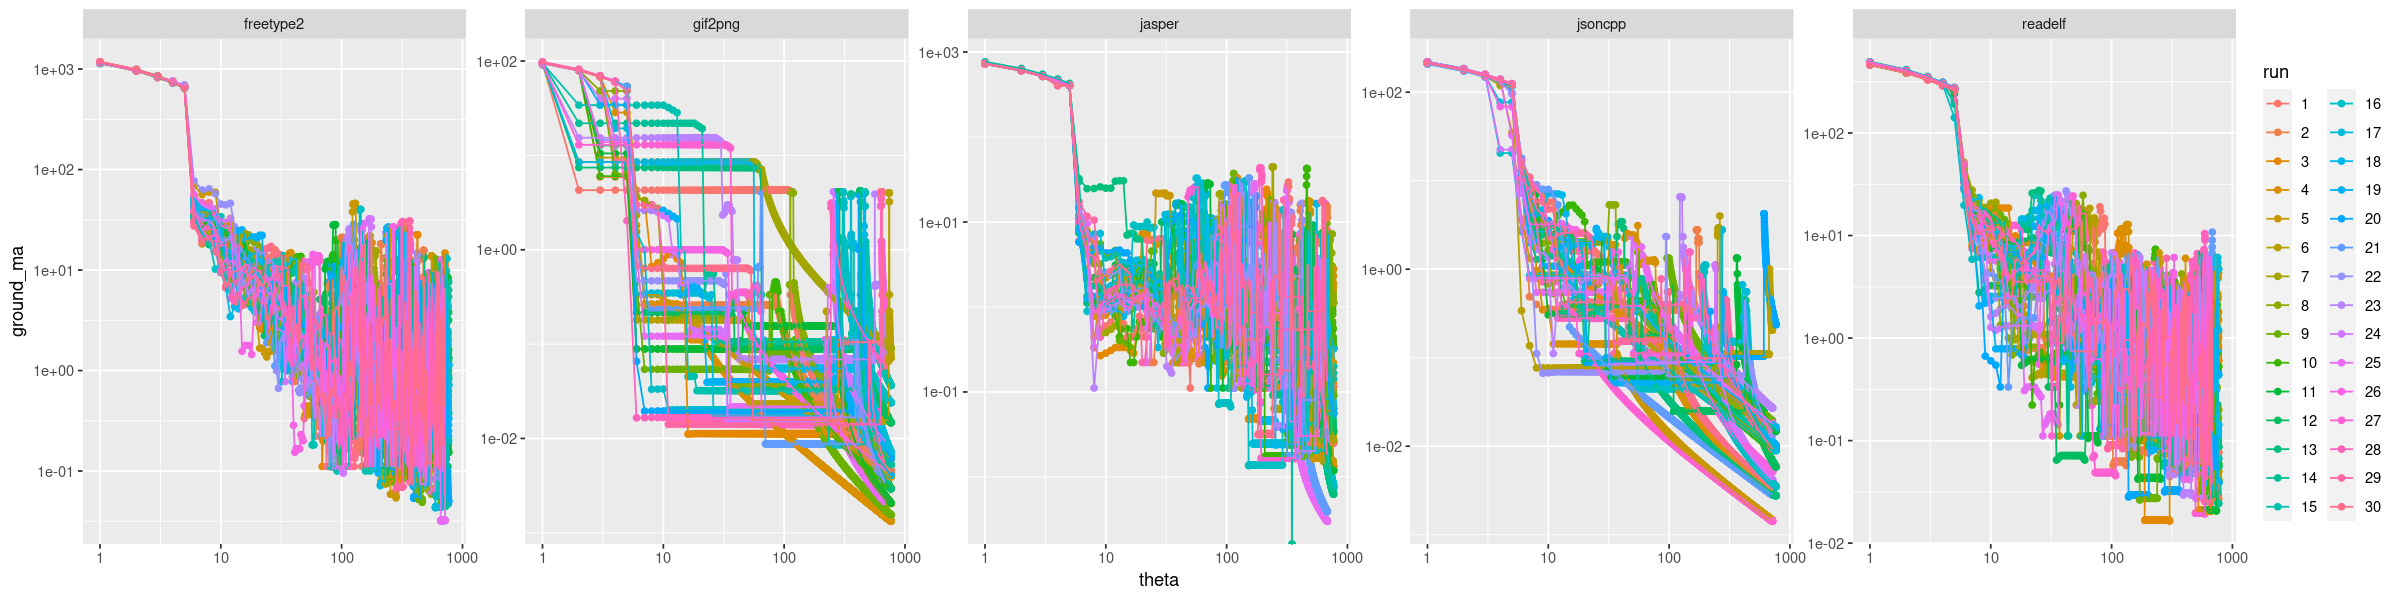

In [6]:
# Function to smooth the empirical coverage rates to obtain ground truth
moving_average = function(x, n = 5) {
    ret = c()
    for (i in 1:length(x)) {
        min_idx = max(1, i - n + 1)
        max_idx = min(length(x), i + n - 1)
        if (sum(x[min_idx:i]) == 0) {
            # find closest non-zero value
            if (min_idx - 1 >= 1) {
                for (j in seq(min_idx - 1, 1, -1)) {
                    if (x[j] > 0) {
                        min_idx = j
                        break
                    }
                }
            }
        }
        if (sum(x[i:max_idx]) == 0) {
            # find closest non-zero value
            if (max_idx + 1 <= length(x)) {
                for (j in seq(max_idx + 1, length(x))) {
                    if (x[j] > 0) {
                        max_idx = j
                        break
                    }
                }
            }
        }
        ret = c(ret, mean(x[min_idx:max_idx]))
    }
    return (ret)
}

# Compute the ground-truth using smoothen species richness curve
gt_data = gb_data %>%
              group_by(subject,run) %>%
              mutate(smooth_gb = sn_gb) %>%
              ungroup()%>%
              group_by(subject,run,theta) %>%
              summarise(mean_sn=mean(smooth_gb),) %>%
              arrange(theta) %>%
              mutate(ground = c(NA, diff(mean_sn))) %>%
              mutate(ground_ma=c(NA,moving_average(diff(mean_sn)))) %>%
              ungroup()

# Plot ground truth
options(repr.plot.width = 20, repr.plot.height = 5)
gt_data %>%
ggplot() +
geom_point(aes(theta,ground_ma,color=run)) + 
geom_line(aes(theta,ground_ma,color=run)) +
scale_x_log10() +
scale_y_log10() +
facet_wrap(~subject,ncol=5,scales="free")

### Showcase Extrapolation Performance

We make predictions at various points (*theta0*) for different horizons (*m*) and compare these predictions against the baseline (i.e. Chao and Jost's extrapolator).

In [7]:
## Showcase an extrapolation scenario for a given subject
selected_sub = "freetype2"
selected_t0 = 150
                            
train_df = train_data %>% filter(subject==selected_sub) %>% filter(theta0<=selected_t0) %>% 
                    mutate(train_limit=exp(seq(log(min(theta)),
                                      log(max(theta0)),length=11))[(10*(1-bet)+1)]) %>% 
                    filter(theta>=train_limit) %>% 
                    group_by(run) %>% 
                    mutate(keep=ifelse((selected_t0-max(theta))>5,0,1)) %>%
                    filter(keep==1)

extra_df = extrapolated %>% filter(subject==selected_sub) %>% 
                    filter(theta0<=selected_t0) %>% filter(theta0==max(theta0)) %>% 
                    filter(prop==3) %>% 
                    filter(run %in% unique(train_df$run))

bb_df = bb_data %>% filter(subject==selected_sub) %>% filter(theta0<=selected_t0) %>%  
                    filter(run %in% unique(train_df$run))

gb_df = gb_data %>% filter(subject==selected_sub) %>% 
                    filter(run %in% unique(train_df$run))


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


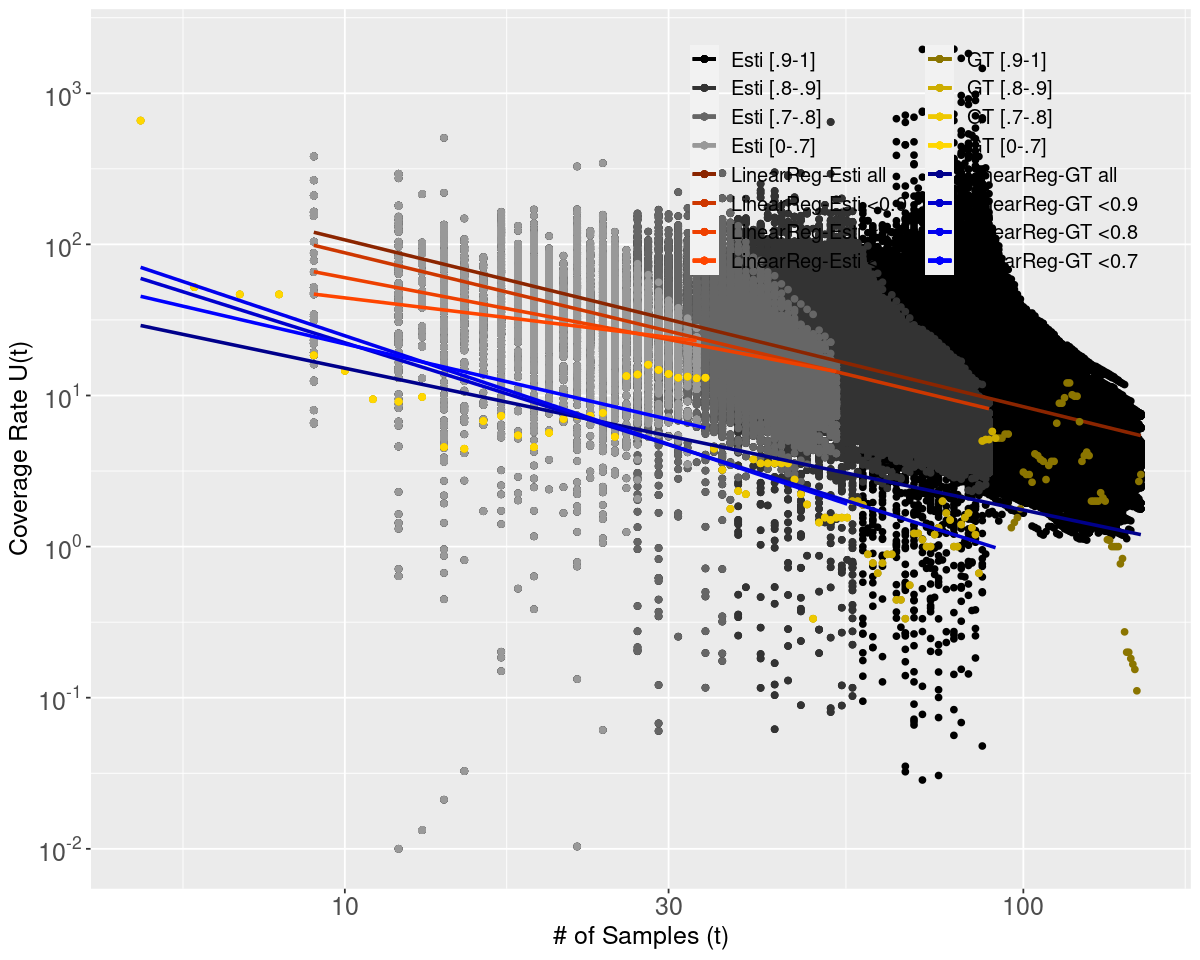

In [8]:
selected_run = 1
threshs = ceiling(exp((log(max(bb_df$theta)) / 10) * 1:10))

# Filter ground truth for the required trial
gt_df = gt_data %>%
    filter(subject == selected_sub) %>%
    filter(run == selected_run)

options(repr.plot.width = 10, repr.plot.height = 8)
plt = ggplot() +
    geom_point(data = bb_df, aes(theta, gt, color = "Esti [.9-1]")) +
    geom_point(data = (bb_df %>% filter(theta0 <= threshs[9])), aes(theta, gt, color = "Esti [.8-.9]")) +
    geom_point(data = (bb_df %>% filter(theta0 <= threshs[8])), aes(theta, gt, color = "Esti [.7-.8]")) +
    geom_point(data = (bb_df %>% filter(theta0 <= threshs[7])), aes(theta, gt, color = "Esti [0-.7]")) +
    geom_smooth(data = bb_df, aes(theta, gt, color = "LinearReg-Esti all"), method = "lm", se = FALSE) +
    geom_smooth(data = (bb_df %>% filter(theta0 <= threshs[9])), aes(theta, gt, color = "LinearReg-Esti <0.9"), 
                method = "lm", se = FALSE) +
    geom_smooth(data = (bb_df %>% filter(theta0 <= threshs[8])), aes(theta, gt, color = "LinearReg-Esti <0.8"), 
                method = "lm", se = FALSE) +
    geom_smooth(data = (bb_df %>% filter(theta0 <= threshs[7])), aes(theta, gt, color = "LinearReg-Esti <0.7"), 
                method = "lm", se = FALSE) +
    geom_point(data = gt_df, aes(theta, ground_ma, color = "GT [.9-1]")) +
    geom_point(data = (gt_df %>% filter(theta <= threshs[9])), aes(theta, ground_ma, color = "GT [.8-.9]")) +
    geom_point(data = (gt_df %>% filter(theta <= threshs[8])), aes(theta, ground_ma, color = "GT [.7-.8]")) +
    geom_point(data = (gt_df %>% filter(theta <= threshs[7])), aes(theta, ground_ma, color = "GT [0-.7]")) +
    geom_smooth(data = gt_df, aes(theta, ground_ma, color = "LinearReg-GT all"), method = "lm", se = FALSE) +
    geom_smooth(data = (gt_df %>% filter(theta <= threshs[9])), aes(theta, ground_ma, color = "LinearReg-GT <0.9"), 
                method = "lm", se = FALSE) +
    geom_smooth(data = (gt_df %>% filter(theta <= threshs[8])), aes(theta, ground_ma, color = "LinearReg-GT <0.8"), 
                method = "lm", se = FALSE) +
    geom_smooth(data = (gt_df %>% filter(theta <= threshs[7])), aes(theta, ground_ma, color = "LinearReg-GT <0.7"), 
                method = "lm", se = FALSE) +
    scale_color_manual("",
        breaks = c(
            "Esti [.9-1]", "Esti [.8-.9]", "Esti [.7-.8]", "Esti [0-.7]", "LinearReg-Esti all", 
            "LinearReg-Esti <0.9", "LinearReg-Esti <0.8", "LinearReg-Esti <0.7",
            "GT [.9-1]", "GT [.8-.9]", "GT [.7-.8]", "GT [0-.7]", "LinearReg-GT all", "LinearReg-GT <0.9", 
            "LinearReg-GT <0.8", "LinearReg-GT <0.7"
        ),
        values = c(
            "black", "grey20", "grey40", "grey60", "orangered4", "orangered3", "orangered2", "orangered1",
            "gold4", "gold3", "gold2", "gold1", "blue4", "blue3", "blue2", "blue1"
        )
    ) +
    theme(
        axis.text.x = element_text(size = 15), axis.text.y = element_text(size = 15), 
        legend.text = element_text(size = 12),
        axis.title.y = element_text(size = 15), legend.title = element_text(size = 15),
        plot.caption = element_text(hjust = 0.5), axis.title.x = element_text(size = 15),
        strip.text.x = element_blank(), strip.text.y = element_text(size = 15)
    ) +
    scale_x_log10("# of Samples (t)", limit = c(5, max(bb_df$theta))) +
    scale_y_log10("Coverage Rate U(t)",
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))
    ) +
    # legend
    theme(legend.position = c(0.75, 0.85), legend.background = element_rect(fill = "transparent", color = NA)) +
    guides(color = guide_legend(ncol = 2))

g = grid.arrange(plt, nrow = 1)
ggsave(file="../figures/Figure-2.png",g,width = 10, height = 8, units = "in", device='png')

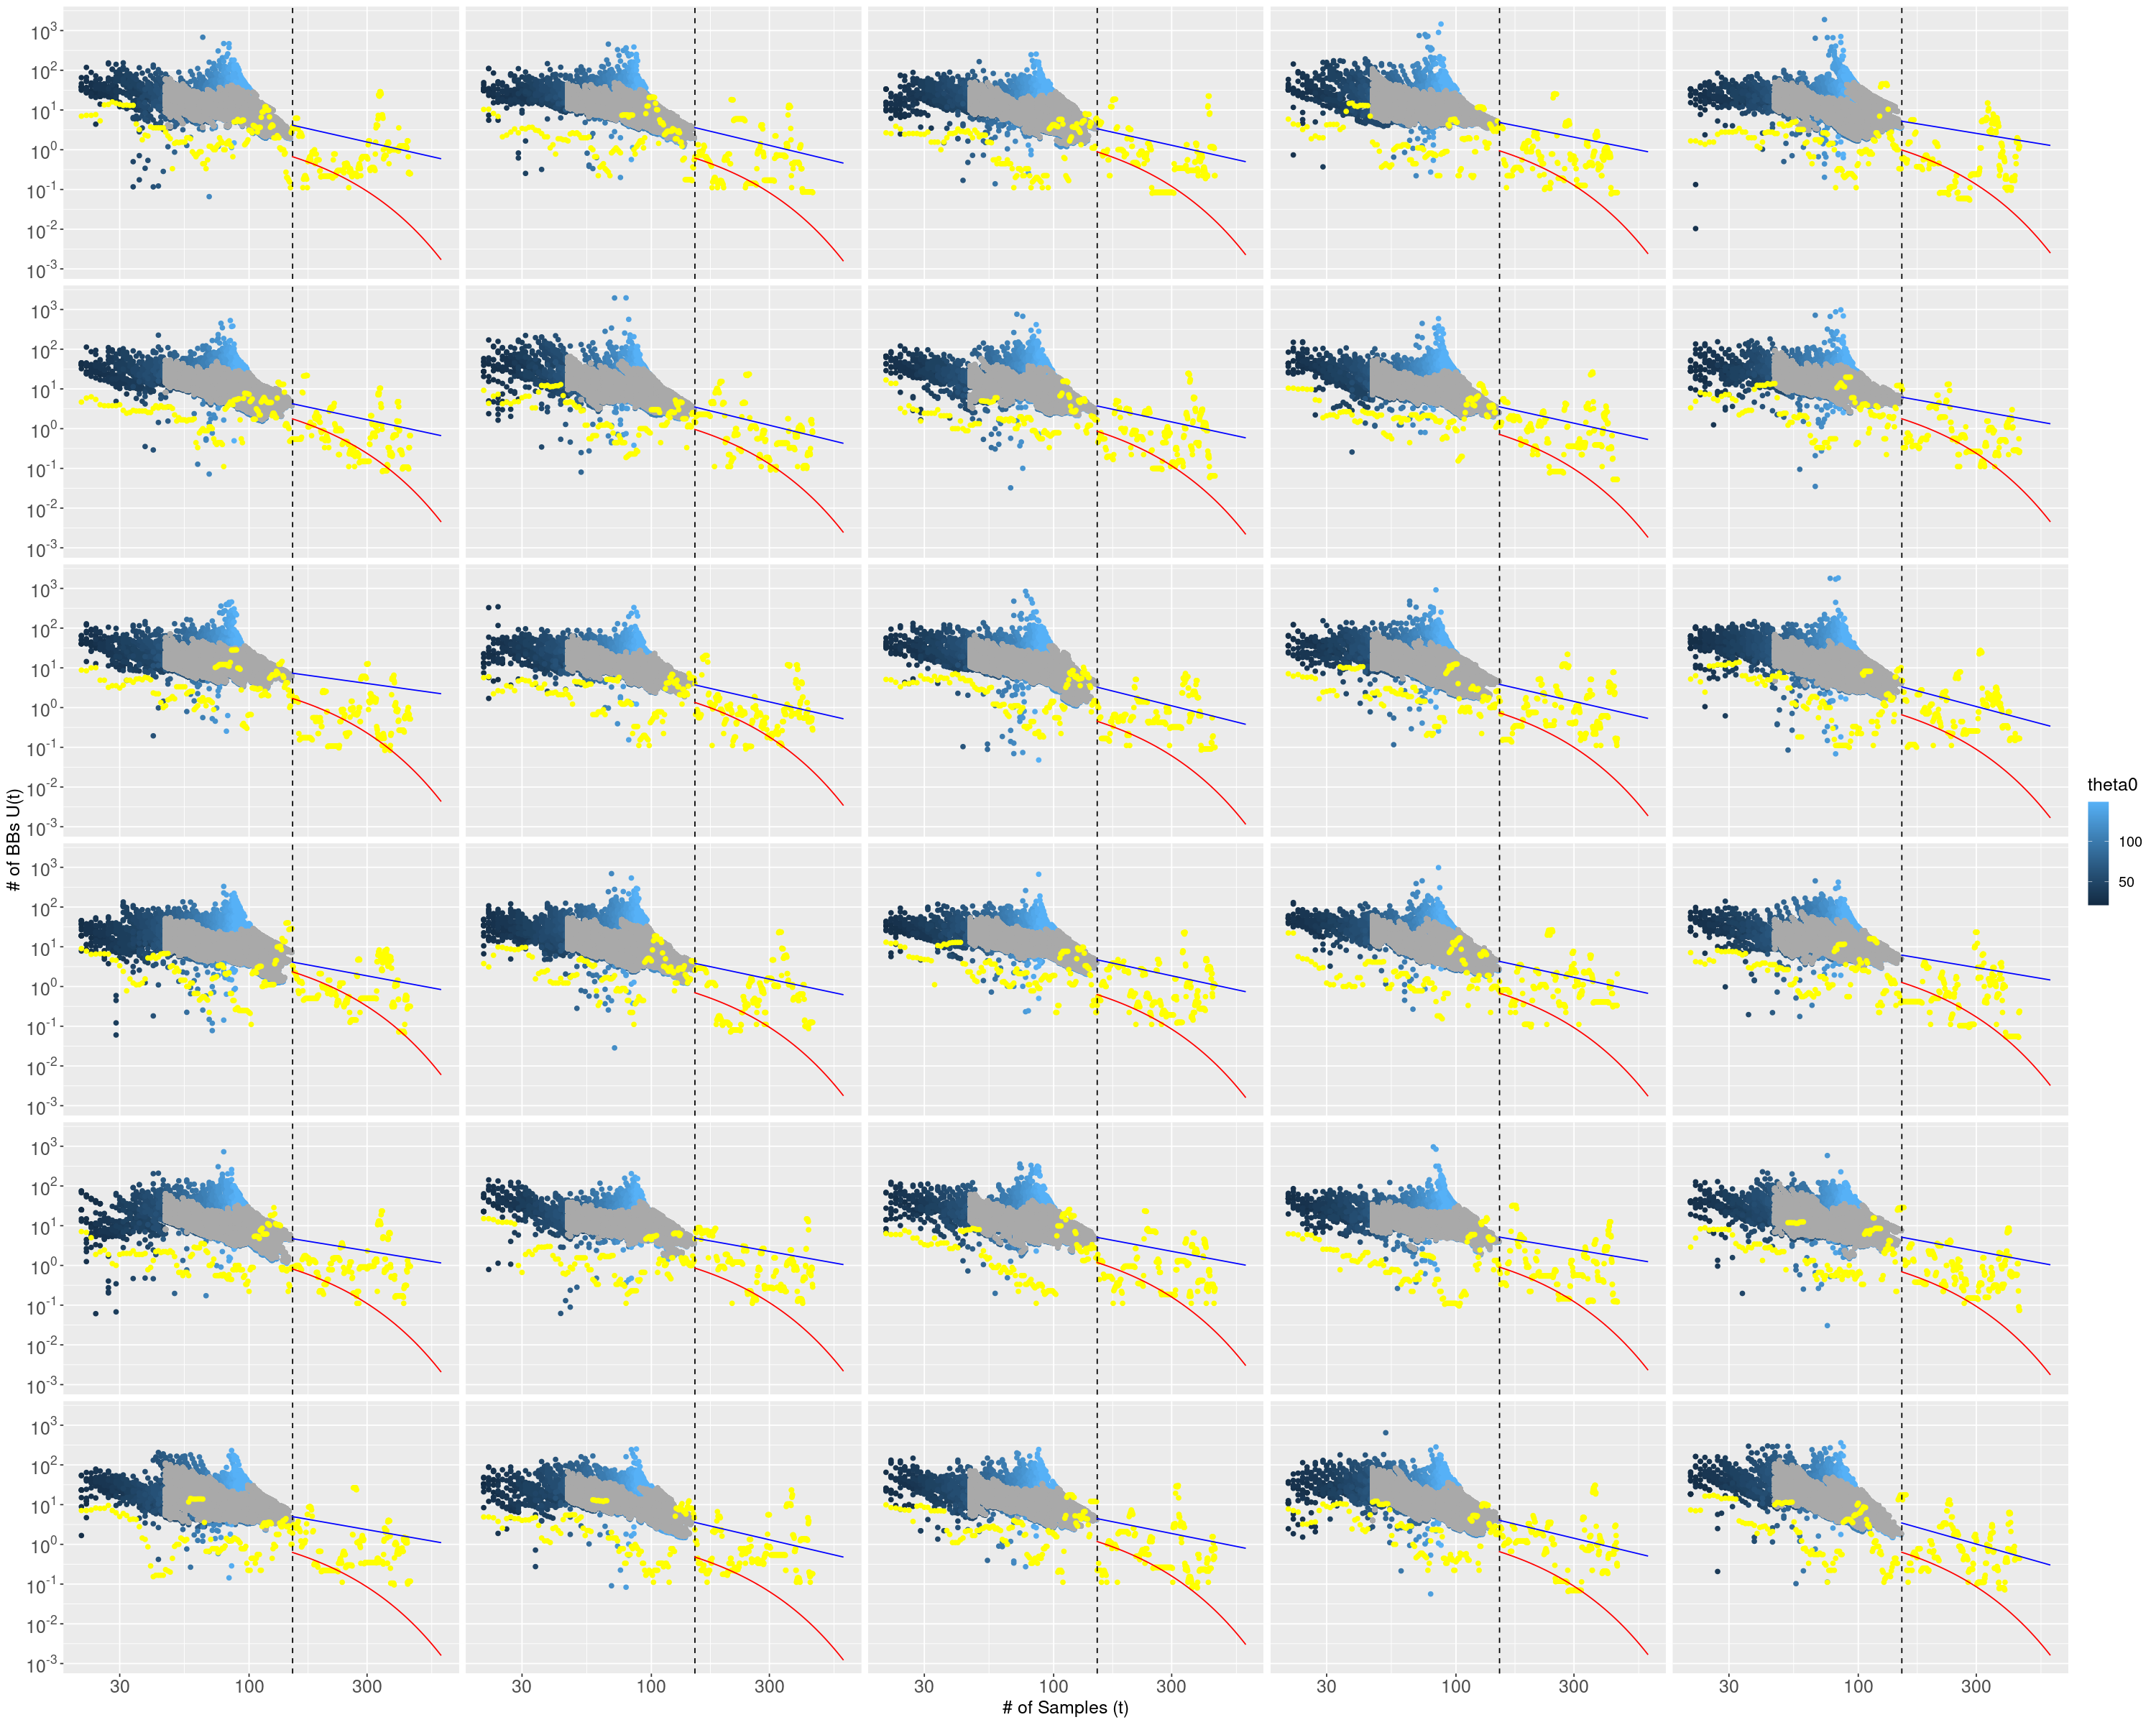

In [9]:
options(repr.plot.width = 25, repr.plot.height = 20)
plt = ggplot() +
    geom_point(data=bb_df %>% filter(theta>20,theta>=round(theta0*bet)),aes(theta,gt,color=theta0)) +
    geom_point(data=train_df %>% filter(theta>20),aes(theta,gt),color="darkgrey") +
    geom_point(data=gt_data %>% filter(theta>20,subject==selected_sub,theta<(3*selected_t0))
                       ,aes(theta,ground_ma),color="yellow") +
    geom_vline(xintercept=selected_t0,linetype="dashed") +
    geom_line(data=extra_df %>% filter(theta>20),aes(theta,delta_new),color="blue") +
    geom_line(data=extra_df %>% filter(theta>20),aes(theta,delta_existing),color="red") +
    #geom_smooth(data=gt_data %>% filter(theta>20,subject==selected_sub,theta<(3*selected_t0)),
    #                                    aes(theta,ground_ma), method = "lm",color="green") + 
    theme(axis.text.x=element_text(size=15),axis.text.y=element_text(size=15),legend.text=element_text(size=12),
          axis.title.y=element_text(size=15),legend.title=element_text(size=15),
          plot.caption = element_text(hjust=0.5),axis.title.x=element_text(size=15),
          strip.text.x = element_blank(),strip.text.y = element_text(size=15)) +
    scale_x_log10("# of Samples (t)") +
    scale_y_log10("# of BBs U(t)",
    breaks = trans_breaks("log10", function(x) 10^x),
    labels = trans_format("log10", math_format(10^.x))) +
    facet_wrap(.~run,ncol=5)

g = grid.arrange(plt, nrow = 1)
ggsave(file="../figures/Extrapolate_showcase.png",g,width = 25, height = 20, units = "in", device='png')

### RQ 1.A - Extrapolator Performance Evaluation

* Generate histograms for the coverage rate and bias distributions to determine whether to use a linear or log scale in the analysis.

* Save these plots as supplementary materials named respectively as ```Figure-S1``` and ```Figure-S2```.

In [10]:
# Filter data
data_scatter = extrapolated %>%
                filter(theta0>=100) %>%
                merge(gt_data,by=c("subject","run","theta"),all.x=TRUE) %>%
                filter(theta >= theta0) %>%
                group_by(subject,theta,theta0,prop) %>%
                summarize(med_error = mean(ground_ma-delta_new),med_gt = mean(ground_ma), .groups="drop")

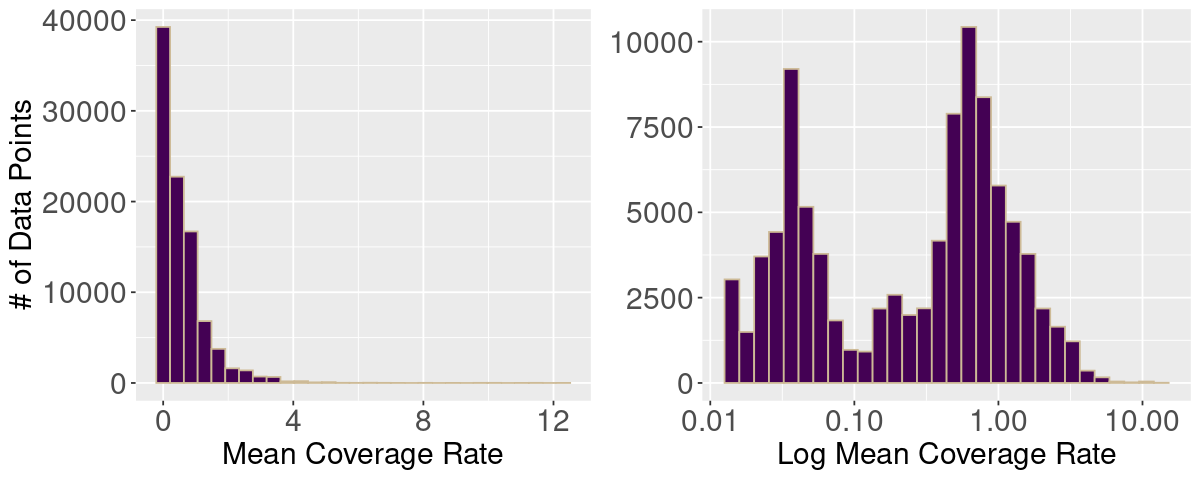

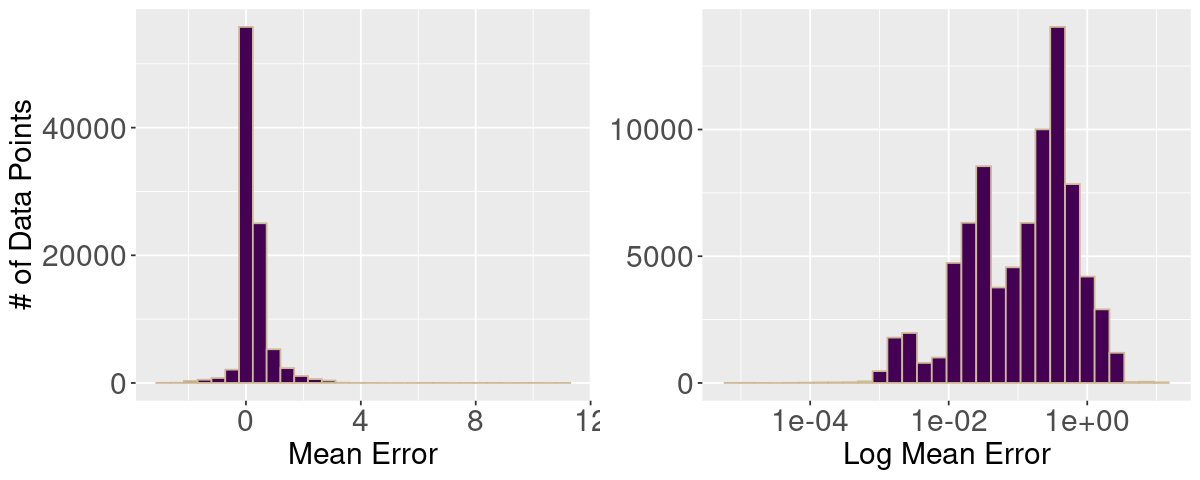

In [11]:
options(repr.plot.width = 10, repr.plot.height = 4)

# Define a color palette from viridis with distinct colors
my_colors = viridis(2, option = "D")  # Use the "D" option for distinct colors

p1 = data_scatter %>% 
    ggplot() +
    geom_histogram(aes(med_gt, fill = "Histogram 1"), bins = 30, col="wheat3") +
    scale_fill_manual(values = my_colors) +
    theme(legend.title = element_blank(), legend.position = "None",
        axis.text.x = element_text(size = 18), axis.title.x = element_text(size = 18),
        axis.text.y = element_text(size = 18), axis.title.y = element_text(size = 18),
        legend.text = element_blank(),
        strip.text.x = element_blank(), strip.text.y = element_text(size = 22)) +
    scale_y_continuous("# of Data Points") +
    scale_x_continuous("Mean Coverage Rate")

p2 = data_scatter %>% 
    ggplot() +
    geom_histogram(aes(med_gt, fill = "Histogram 2"), bins = 30, col="wheat3") +
    scale_fill_manual(values = my_colors) +
    theme(legend.title = element_blank(), legend.position = "None",
        axis.text.x = element_text(size = 18), axis.title.x = element_text(size = 18),
        axis.text.y = element_text(size = 18), axis.title.y = element_blank(),
        legend.text = element_blank(),
        strip.text.x = element_blank(), strip.text.y = element_text(size = 22)) +
    scale_y_continuous("# of Data Points") +
    scale_x_log10("Log Mean Coverage Rate")

p3 = data_scatter %>% 
    ggplot() +
    geom_histogram(aes(med_error, fill = "Histogram 1"), bins = 30, col="wheat3") +
    scale_fill_manual(values = my_colors) +
    theme(legend.title = element_blank(), legend.position = "None",
        axis.text.x = element_text(size = 18), axis.title.x = element_text(size = 18),
        axis.text.y = element_text(size = 18), axis.title.y = element_text(size = 18),
        legend.text = element_blank(),
        strip.text.x = element_blank(), strip.text.y = element_text(size = 22)) +
    scale_y_continuous("# of Data Points") +
    scale_x_continuous("Mean Error")

p4 = data_scatter %>% 
    ggplot() +
    geom_histogram(aes(med_error, fill = "Histogram 2"), bins = 30, col="wheat3") +
    scale_fill_manual(values = my_colors) +
    theme(legend.title = element_blank(), legend.position = "None",
        axis.text.x = element_text(size = 18), axis.title.x = element_text(size = 18),
        axis.text.y = element_text(size = 18), axis.title.y = element_blank(),
        legend.text = element_blank(),
        strip.text.x = element_blank(), strip.text.y = element_text(size = 22)) +
    scale_y_continuous("# of Data Points") +
    scale_x_log10("Log Mean Error")

g = grid.arrange(p1, p2, nrow = 1)
ggsave("../figures/Figure-S1.pdf",g,width=10,height=4)

g = grid.arrange(p3, p4, nrow = 1)
ggsave("../figures/Figure-S2.pdf",g,width=10,height=4)

#### Comparing the extrapolator performance through bias

In [12]:
## Compute Mean Bias of Extrapolations
bias_df = extrapolated %>%
            filter(theta0>=100) %>%
            merge(gt_data,by=c("subject","run","theta"),all.x=TRUE) %>%
            mutate(delta_existing=log(delta_existing),delta_new=log(delta_new),ground=log(ground_ma)) %>%
            group_by(subject,run,theta0,prop) %>%
            summarize(bias_existing=mean(delta_existing-ground,na.rm=TRUE),
                      bias_new=mean(delta_new-ground,na.rm=TRUE), .groups = "drop") %>%
            ungroup()

bias_df = bias_df %>%
            filter((theta0+prop*theta0)<=max(theta0)) %>%
            group_by(subject,run,theta0,prop) %>%
            pivot_longer(!c(subject,run,theta0,prop),names_to = "method", values_to = "value") %>%
            ungroup()


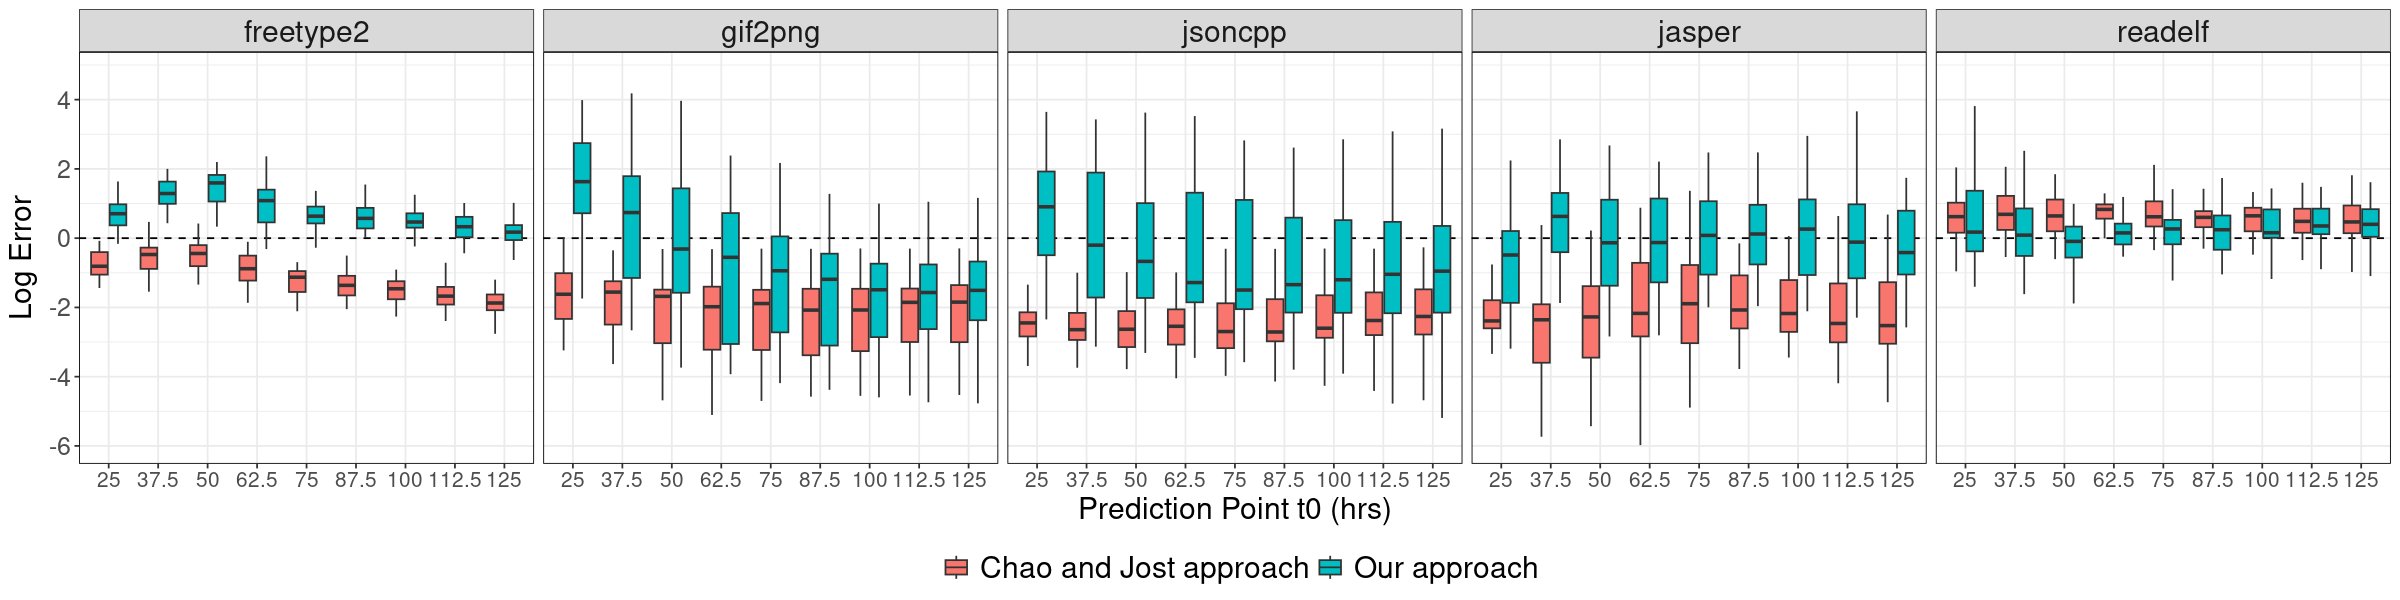

In [13]:
selected_prop = 0.5

bias_result_prop = bias_df %>%
                 filter(prop==selected_prop)

options(repr.plot.width = 20, repr.plot.height = 5)
p1 = bias_result_prop %>%
    filter(method=="bias_existing" | method=="bias_new") %>%
    mutate(method=ifelse(method=="bias_existing","Chao and Jost approach","Our approach")) %>%
    mutate(theta0=as.factor(theta0*(1/4))) %>%
    ggplot() +
    geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 0.5) +
    geom_boxplot(aes(x=theta0,y=value,fill=method),outlier.shape = NA, outlier.colour = NA) +
    theme_bw() +
    theme(panel.border = element_rect(color = "black"),
    axis.title.x = element_text(size=18), legend.title = element_blank(),legend.position = "bottom",
    legend.text=element_text(size=18),
    axis.text.x=element_text(size=12.5),
    axis.text.y=element_text(size=15),axis.title.y=element_text(size=18),
    strip.text.x = element_text(size=18),strip.text.y = element_text(size=18)) +
    scale_y_continuous("Log Error", breaks = pretty_breaks()) +
    #labels = trans_format("log10", math_format(10^.x)),limits=c(10^(-1),10^(1.5))) + 
    facet_grid(~subject,scales="free") +
    xlab("Prediction Point t0 (hrs)")
                  
plot_grid(p1, ncol = 1, align = "v")
ggsave("../figures/Figure-4.pdf",width=20,height=4)

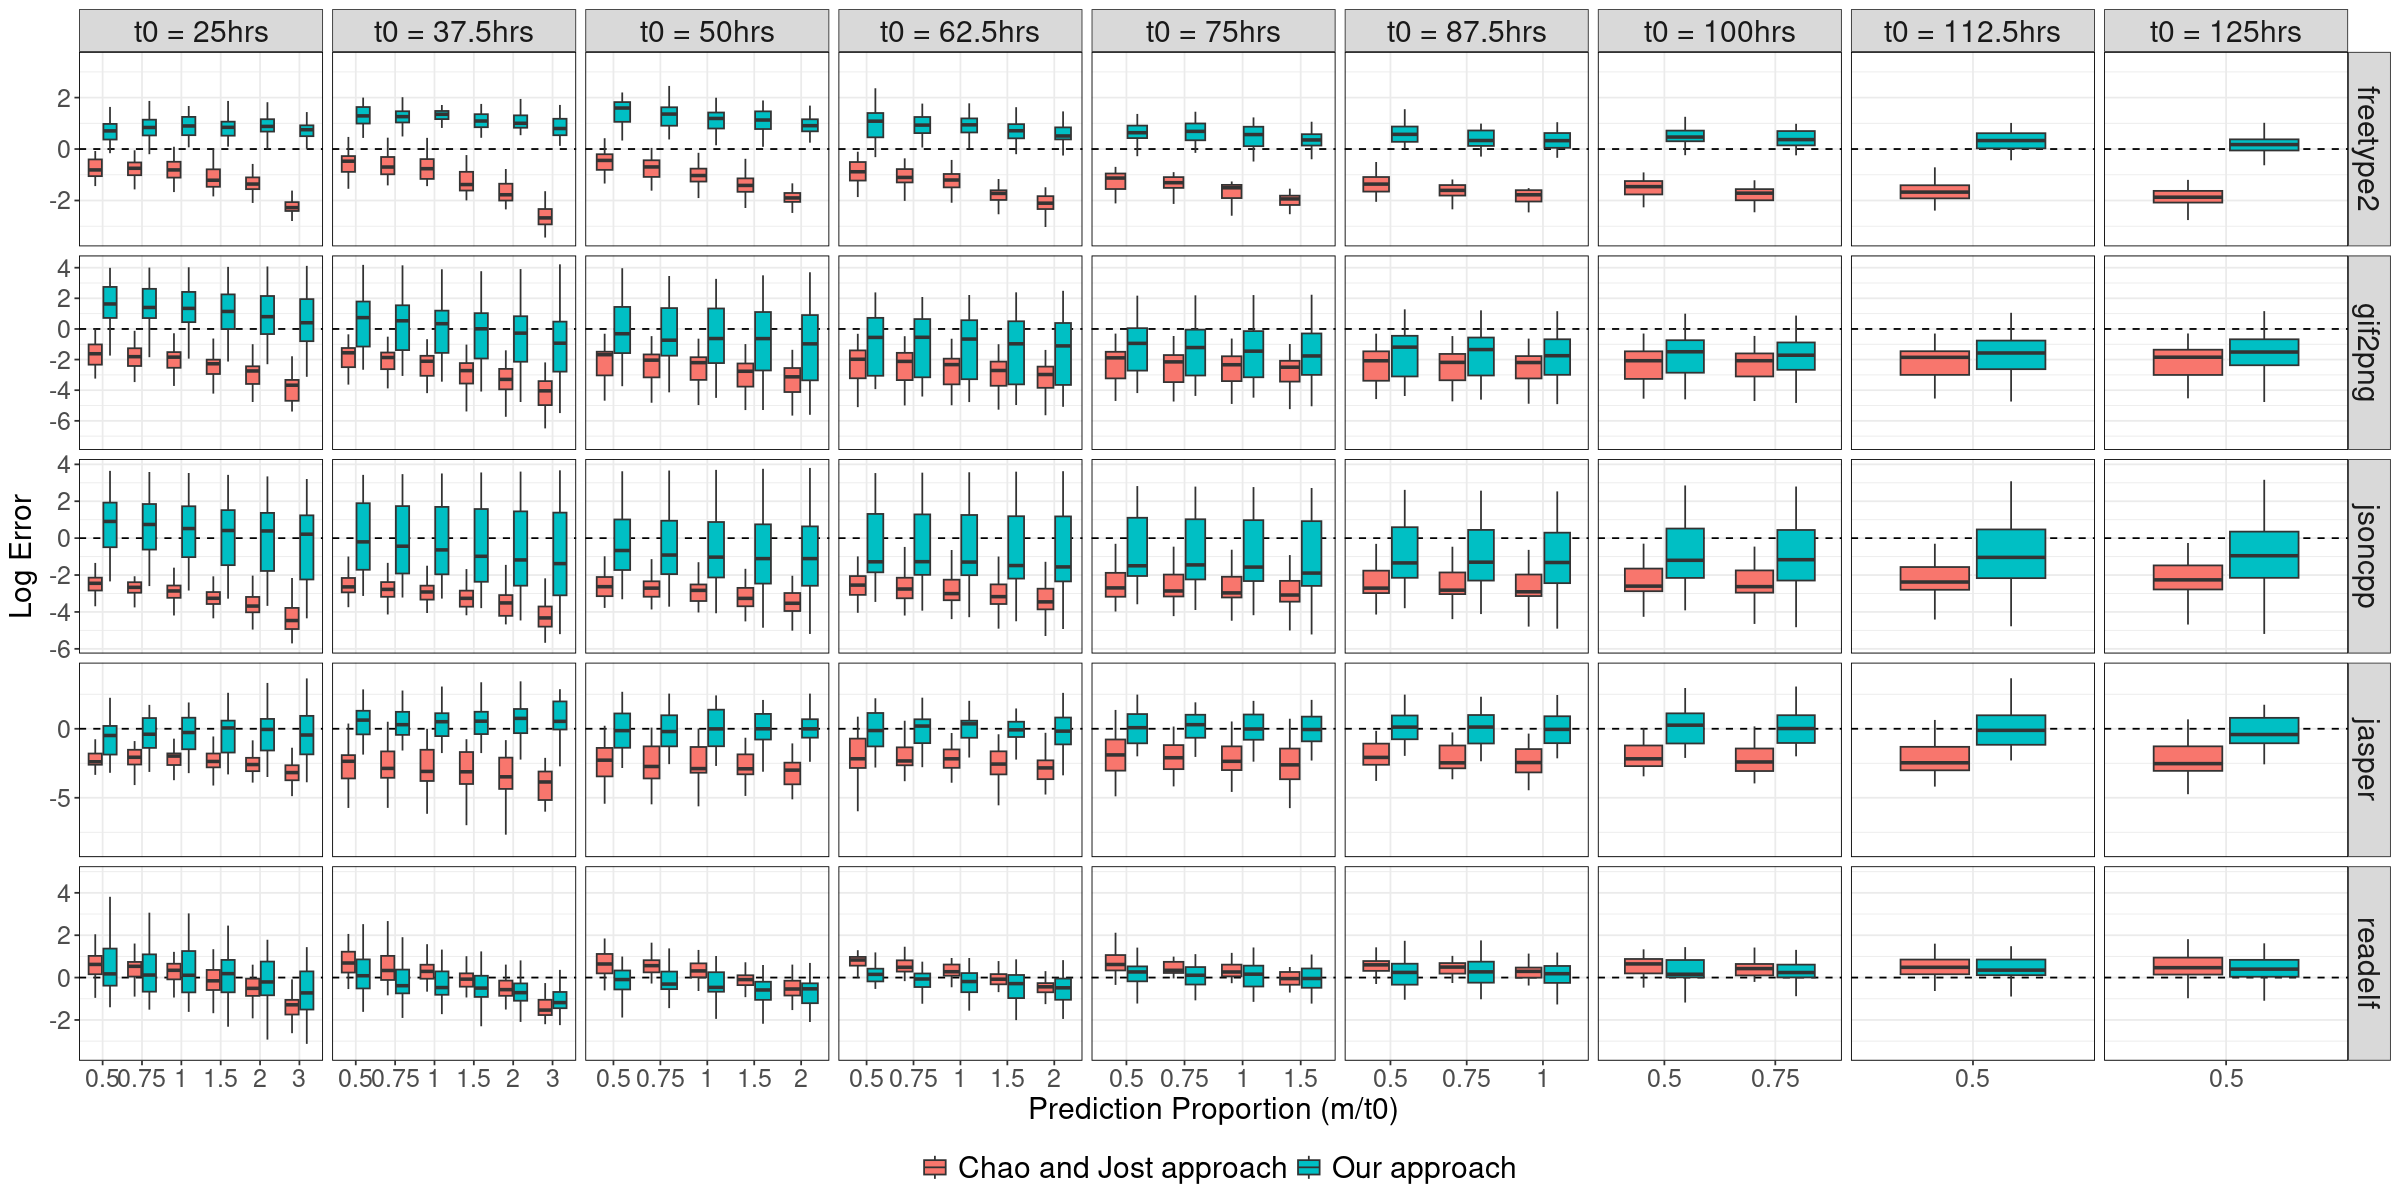

In [14]:
options(repr.plot.width = 20, repr.plot.height = 10)

p1 = bias_df %>%
        filter(method == "bias_existing" | method == "bias_new") %>%
        mutate(method = ifelse(method == "bias_existing", "Chao and Jost approach", "Our approach")) %>%
        arrange(theta0) %>%
        mutate(theta0 = as.factor(theta0 * (1/4))) %>%
        mutate(prop = factor(prop), theta0 = factor(paste("t0 = ", theta0, "hrs", sep = ""),
                                                  c(paste("t0 = ", seq(50, 500, by = 50) * (1/4), "hrs", sep = "")))) %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 0.5) +
        geom_boxplot(aes(x = prop, y = value, fill = method),outlier.shape = NA, outlier.colour = NA) +
        labs(x="Prediction Proportion (m/t0)") +
        theme_bw() +
        theme(panel.border = element_rect(color = "black"),
         legend.title = element_blank(),legend.position = "bottom",
         axis.text.x=element_text(size=15),axis.title.x=element_text(size=18),
         axis.text.y=element_text(size=15),axis.title.y=element_text(size=18),
         legend.text=element_text(size=18),
         strip.text.x = element_text(size=18),strip.text.y = element_text(size=18)) +
        scale_y_continuous("Log Error", breaks = pretty_breaks()) + 
        facet_grid(subject~theta0,scales="free")

plot_grid(p1, ncol = 1, align = "v")
ggsave("../figures/Figure-5.pdf",width=20,height=10)

Statistical test to evaluate the difference in biases.

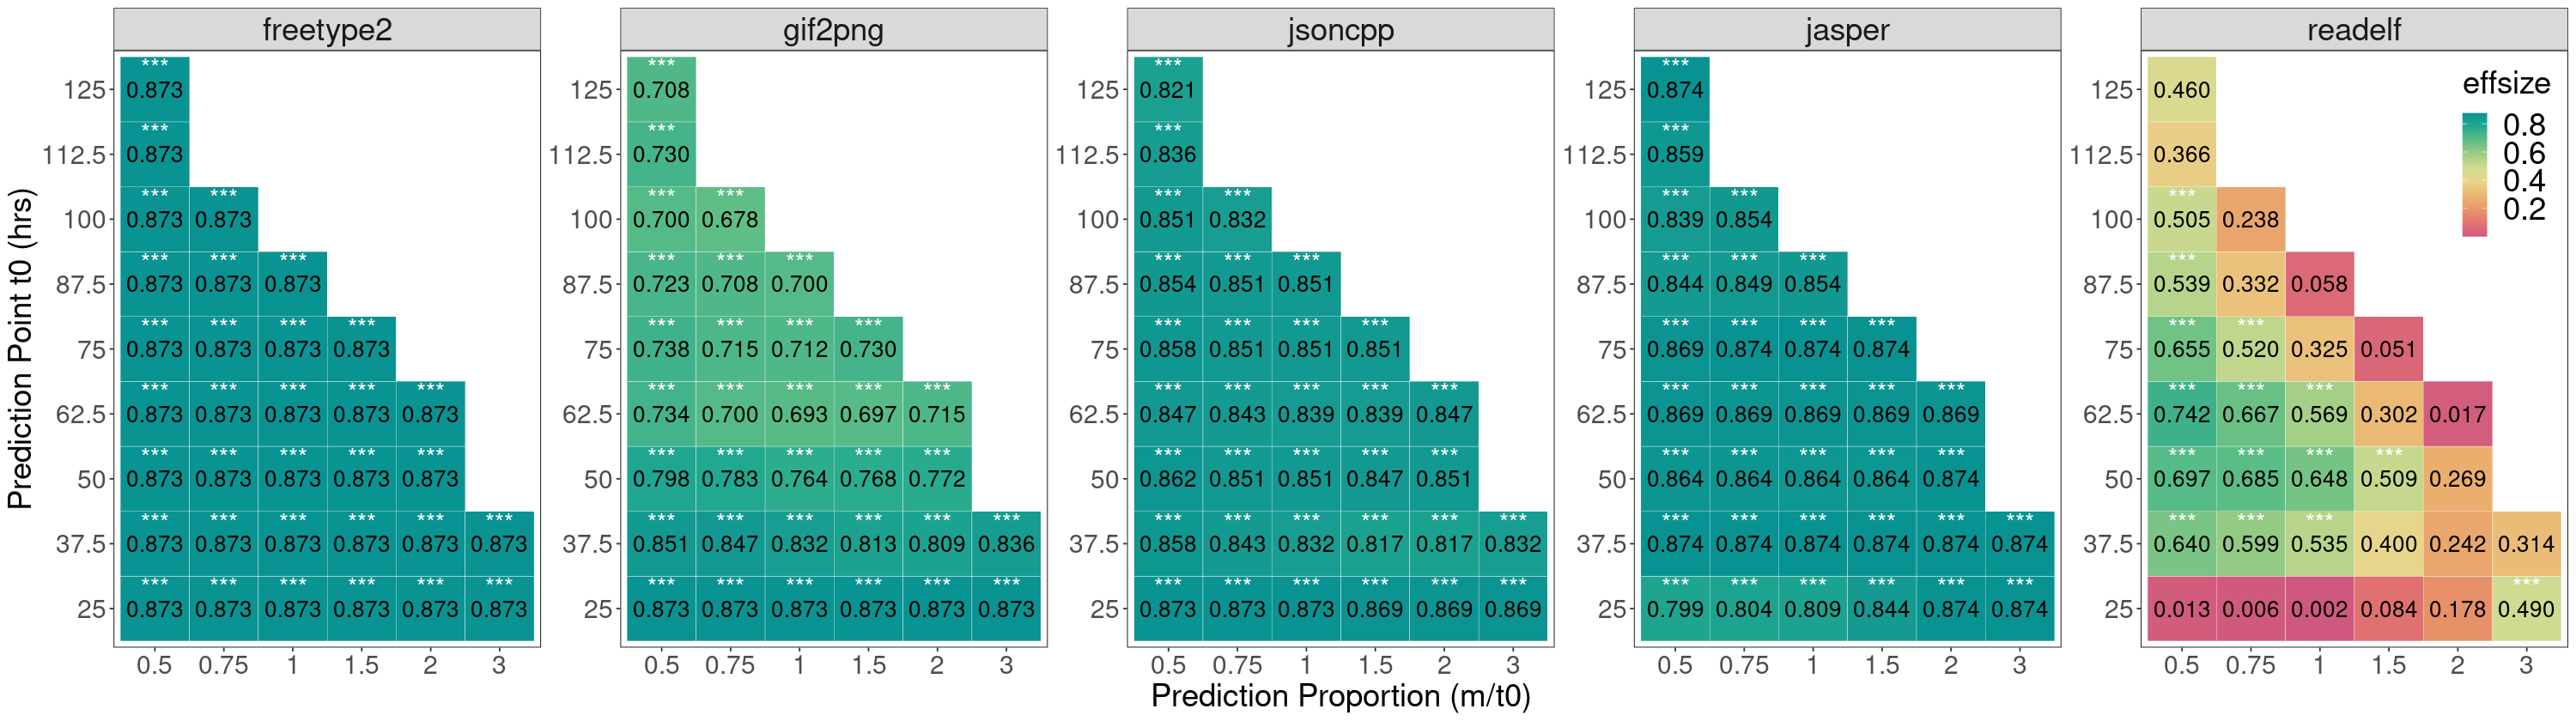

In [15]:
# Heat map
ALTERNATE = "two.sided"
eff_size = merge(
            bias_df %>% 
            filter(method=="bias_existing" | method=="bias_new") %>%
            filter_all(all_vars(!is.infinite(.))) %>%
            drop_na() %>%
            distinct() %>%
            group_by(subject,run,theta0,prop) %>%
            mutate(freq=n()) %>%
            filter(freq==2) %>%
            ungroup() %>%
            group_by(subject,theta0,prop) %>%
            wilcox_effsize(value ~ method,alternate=ALTERNATE,paired=TRUE,conf.level=0.99) %>%
            ungroup() %>%
            select(subject,theta0,prop,effsize),
            bias_df %>% 
            filter(method=="bias_existing" | method=="bias_new") %>%
            filter_all(all_vars(!is.infinite(.))) %>%
            drop_na() %>%
            distinct() %>%
            group_by(subject,run,theta0,prop) %>%
            mutate(freq=n()) %>%
            filter(freq==2) %>%
            ungroup() %>%
            group_by(subject,theta0,prop) %>%
            summarise(p.value=wilcox.test(value ~ method,alternative=ALTERNATE,paired=TRUE,conf.level=0.99)$p.value, 
                      .groups = "drop") %>%
            ungroup(),
            by=c("subject","theta0","prop"))

eff_size = eff_size %>% mutate(theta0=factor(theta0*(1/4)))

eff_size$theta0 = factor(eff_size$theta0, levels=seq(50,max(gb_data$theta),by=50)*(1/4))
eff_size$prop = factor(eff_size$prop, levels=c(0.5,0.75,1,1.5,2,3))

options(repr.plot.width = 25, repr.plot.height = 7)
pp = eff_size %>%
    rename(t0=theta0,proportion=prop) %>%
    ggplot(aes(x = proportion, y = t0, fill = effsize)) +
    geom_tile(color="white") +
    geom_text(aes(label = format(effsize, scientific = FALSE, digits = 1)), color = "black", size = 5.5) +
    geom_text(aes(label = ifelse(p.value<=0.01,"***","")), color = "white", size = 6, vjust = -0.7) +
    scale_fill_gradientn(colors = hcl.colors(10, "Temps", rev = TRUE)) +
    theme_bw() +
    theme(panel.border = element_rect(color = "black"),
         panel.grid.major = element_blank(),panel.grid.minor = element_blank(),
         axis.text.x=element_text(size=18),strip.text.x = element_text(size=22),
         axis.title.x=element_text(size=22),strip.text.y = element_text(size=22),
         axis.text.y=element_text(size=18),
         axis.title.y=element_text(size=22),
         legend.text=element_text(size=22),
         legend.title=element_text(size=22),legend.position=c(0.975,0.83)) +
    xlab("Prediction Proportion (m/t0)") + 
    ylab("Prediction Point t0 (hrs)") +
    facet_wrap(~subject,scales="free",nrow=1)

g = grid.arrange(pp, nrow = 1)
ggsave("../figures/Figure-6.pdf",g,width=25,height=7)

### RQ 1.B - Accuracy at the Prediction of a Given Threshold

In this analysis, we assess the accuracy of our extrapolator in predicting the ground truth values observed at a specific threshold coverage rate.

In [16]:
# Filter required data for the analysis
prediction_fit = extrapolated %>%
                filter(theta0>=100) %>% 
                merge(gt_data,by=c("subject","run","theta"),all.x=TRUE) %>%
                filter(theta >= theta0) %>%
                select(subject,run,theta,theta0,prop,delta_existing,delta_new,ground_ma,mean_sn)

In [17]:
# Set the window size at the pivotal point
k = 37.5

# Set the threshold for each subject as the median of the ground truth
thresh_df = prediction_fit %>%
    group_by(subject) %>%
    arrange(theta) %>%
    summarise(threshold = median(ground_ma), .groups = "drop") %>%
    ungroup()

subjects = thresh_df$subject
thresholds = thresh_df$threshold

fit_df = tibble()

for (i in 1:length(subjects)) {
    selected_sub = subjects[i]
    threshold = thresholds[i]

    fit_new = prediction_fit %>%
        filter(subject == selected_sub) %>%
        mutate(threshold = threshold, passed_cutoff = ifelse(threshold > delta_new, 1, 0)) %>%
        group_by(subject, run, theta0, threshold) %>%
        arrange(theta) %>%
        filter(passed_cutoff == 1) %>%
        mutate(pivotal_point = ifelse(abs(delta_new - threshold) == min(abs(delta_new - threshold)), theta, 0)) %>%
        mutate(take = ifelse(k >= abs(theta - max(pivotal_point)), 1, 0)) %>%
        select(-prop) %>%
        distinct() %>%
        summarise(
            theta = theta[pivotal_point > 0], delta_new = delta_new[pivotal_point > 0],
            avg_ground_new = mean(ground_ma[take == 1]), .groups = "drop"
        ) %>%
        ungroup() %>%
        mutate(deviation_new = avg_ground_new - delta_new, theta_new = theta, deviation_new_rel = deviation_new / threshold)

    fit_existing = prediction_fit %>%
        filter(subject == selected_sub) %>%
        mutate(threshold = threshold, passed_cutoff = ifelse(threshold > delta_existing, 1, 0)) %>%
        group_by(subject, run, theta0, threshold) %>%
        arrange(theta) %>%
        filter(passed_cutoff == 1) %>%
        mutate(pivotal_point = ifelse(abs(delta_existing - threshold) == min(abs(delta_existing - threshold)), theta, 0)) %>%
        mutate(take = ifelse(k >= abs(theta - max(pivotal_point)), 1, 0)) %>%
        select(-prop) %>%
        distinct() %>%
        summarise(
            theta = theta[pivotal_point > 0], delta_existing = delta_existing[pivotal_point > 0],
            avg_ground_existing = mean(ground_ma[take == 1]), .groups = "drop"
        ) %>%
        ungroup() %>%
        mutate(deviation_existing = avg_ground_existing - delta_existing, theta_existing = theta, deviation_existing_rel = deviation_existing / threshold)

    combined = merge(fit_new, fit_existing, by = c("subject", "run", "theta0", "threshold"))
    fit_df = rbind(fit_df, combined)
}

fit_df = fit_df %>%
    select(subject, run, theta0, threshold, deviation_new, deviation_existing, deviation_new_rel, deviation_existing_rel) %>%
    pivot_longer(!c(subject, run, theta0, threshold), names_to = "method", values_to = "value")

fit_df = fit_df %>%
    group_by(subject, run, theta0, threshold) %>%
    mutate(count = n()) %>%
    filter(count == 4)

In [18]:
sub_df = fit_df %>%
        group_by(subject,run,theta0,threshold) %>% 
        dcast(subject + run + theta0 + threshold ~ method, value.var = "value") %>%
        mutate(diff = abs(deviation_existing) - abs(deviation_new)) %>%
        mutate(diff_rel = abs(deviation_existing_rel) - abs(deviation_new_rel)) %>%
        mutate(theta0 = as.factor(theta0),
    # sub_df without outliers
    dev_exist_rel_min = quantile(deviation_existing_rel, 0.25) - 1.5 * IQR(deviation_existing_rel),
    dev_exist_rel_max = quantile(deviation_existing_rel, 0.75) + 1.5 * IQR(deviation_existing_rel),
    dev_new_rel_min = quantile(deviation_new_rel, 0.25) - 1.5 * IQR(deviation_new_rel),
    dev_new_rel_max = quantile(deviation_new_rel, 0.75) + 1.5 * IQR(deviation_new_rel),
    diff_rel_min = quantile(diff_rel, 0.25) - 1.5 * IQR(diff_rel),
    diff_rel_max = quantile(diff_rel, 0.75) + 1.5 * IQR(diff_rel)) %>%
    filter(deviation_existing_rel >= dev_exist_rel_min, deviation_existing_rel <= dev_exist_rel_max,
           deviation_new_rel >= dev_new_rel_min, deviation_new_rel <= dev_new_rel_max,
           diff_rel >= diff_rel_min, diff_rel <= diff_rel_max) %>%
    select(subject,run,theta0,threshold,deviation_existing_rel,deviation_new_rel,diff_rel) %>%
    pivot_longer(!c(subject, run, theta0, threshold), names_to = "method", values_to = "value")
    

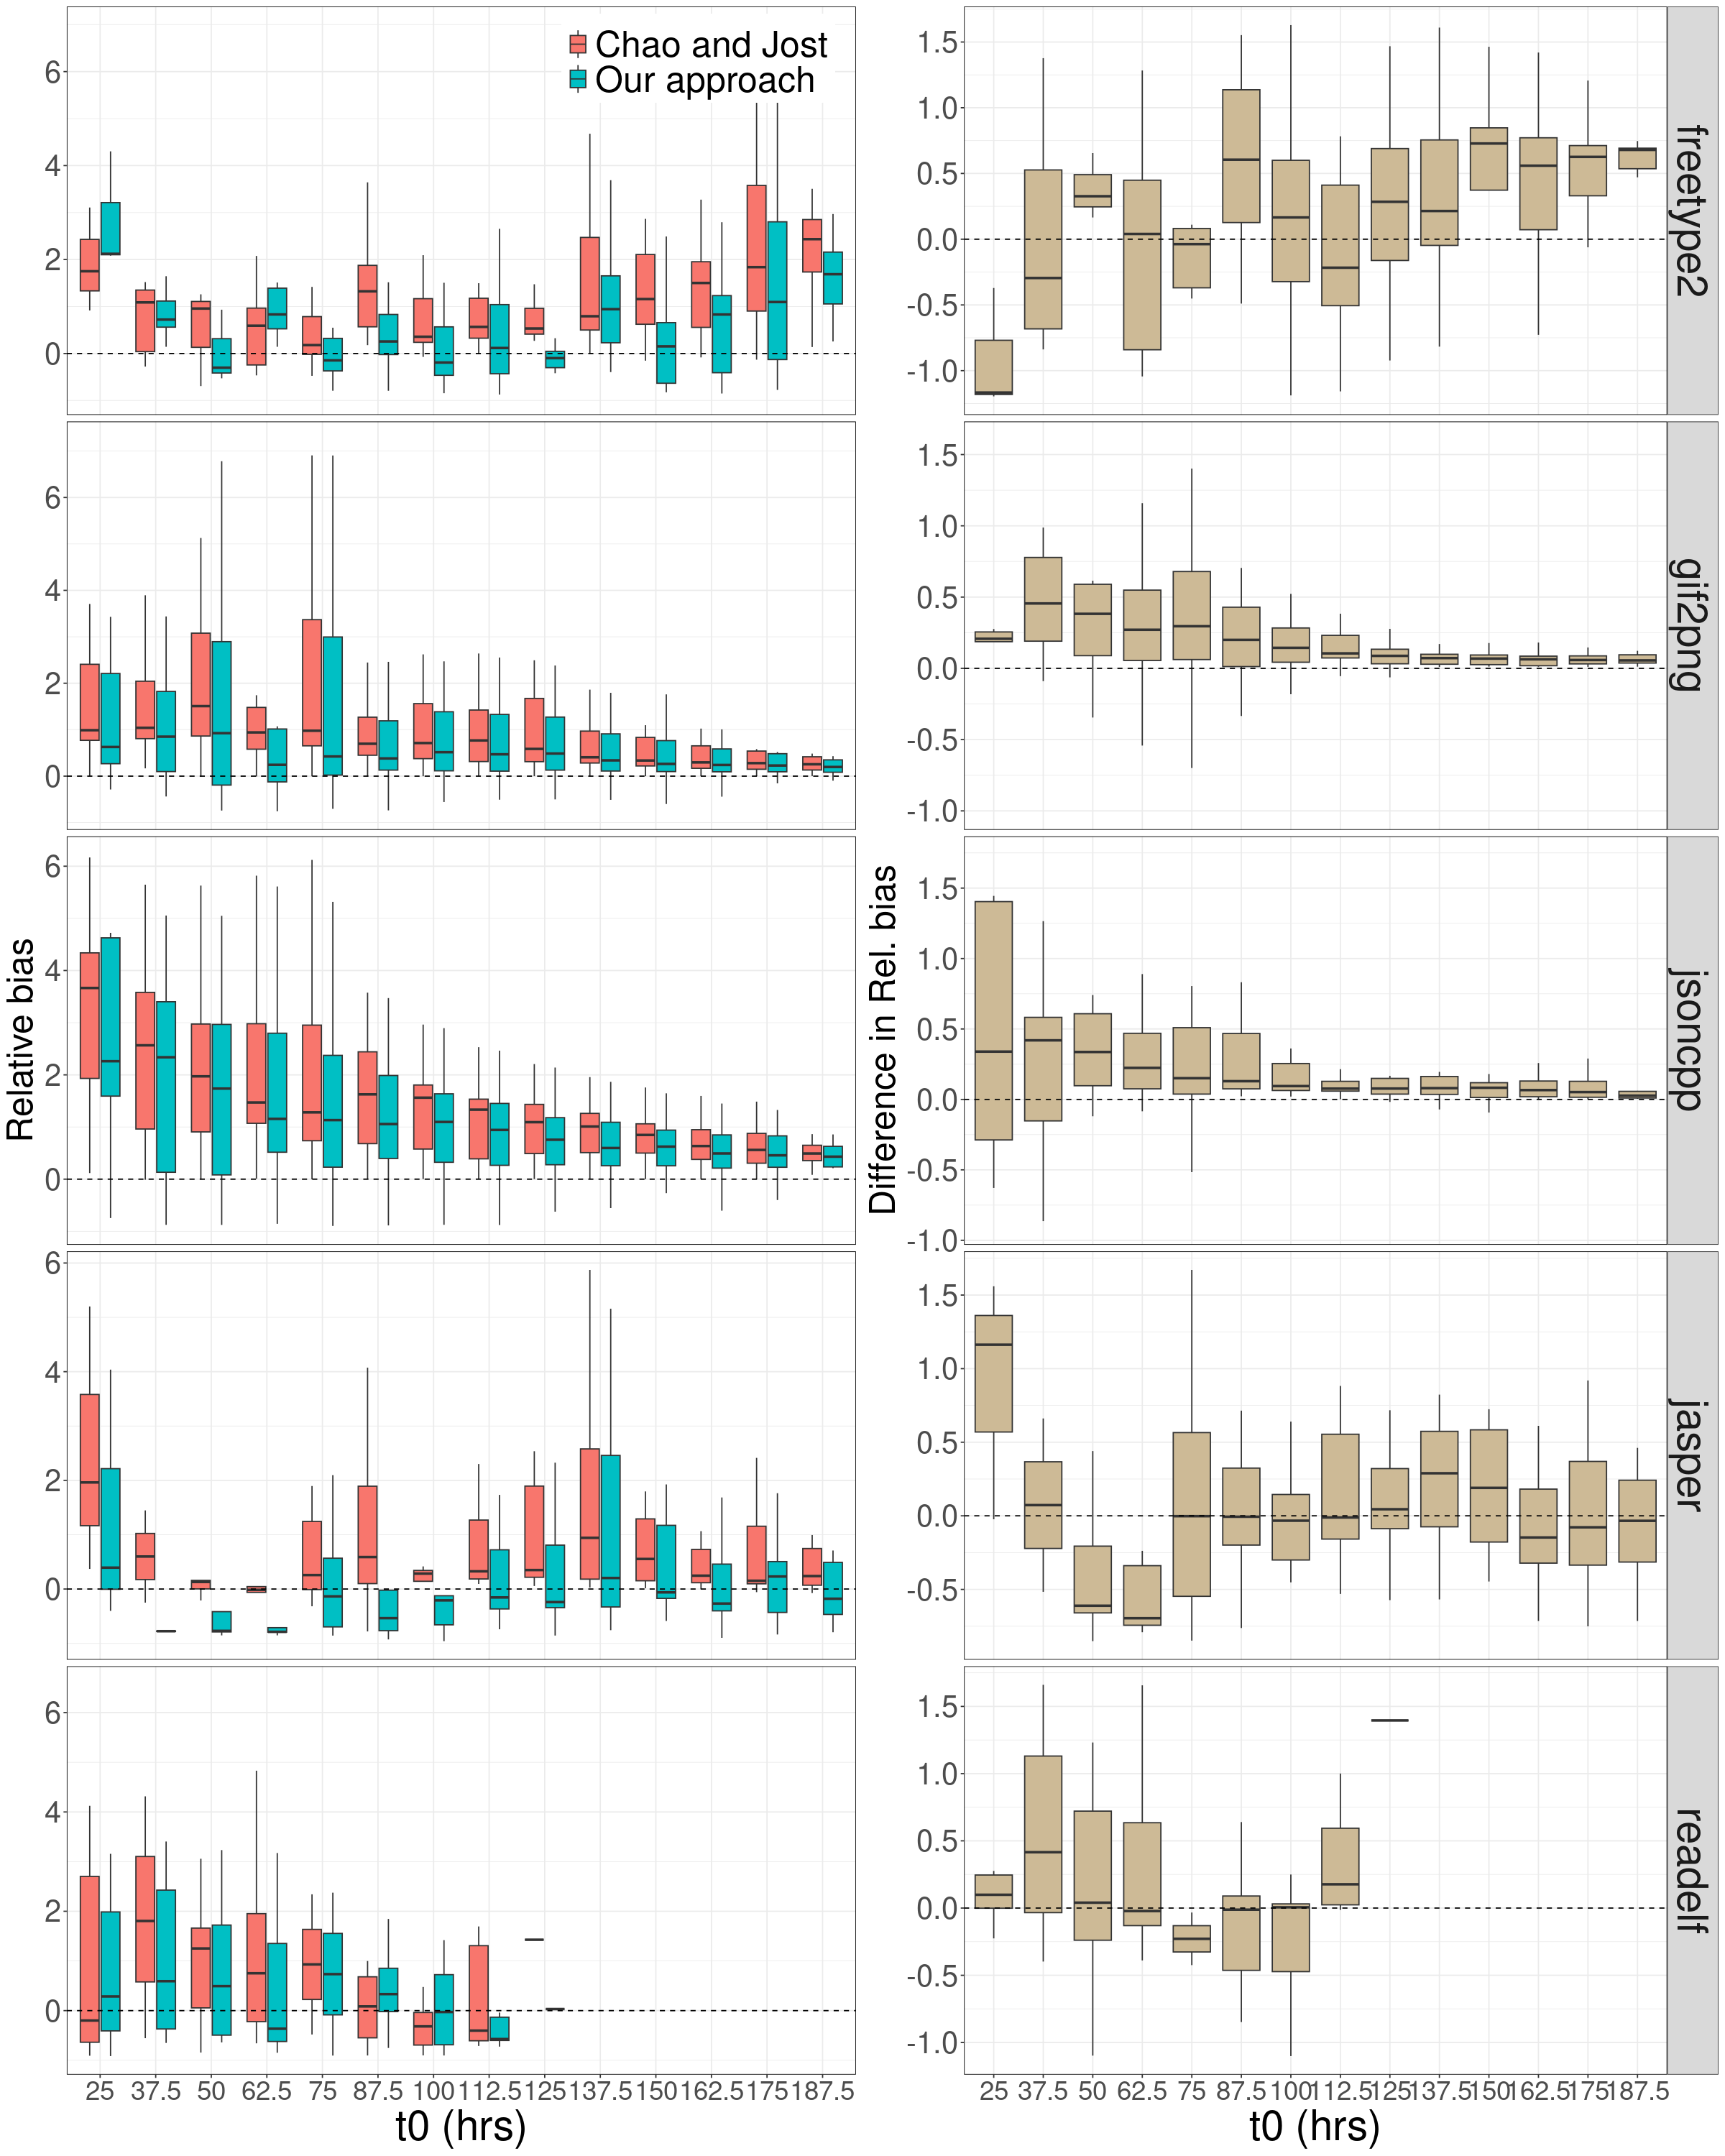

In [19]:
# Plot the relative bias results
options(repr.plot.width = 20, repr.plot.height = 25)

p1 = sub_df %>%
    filter(method != "diff_rel") %>%
    mutate(method = ifelse(method == "deviation_existing_rel", "Chao and Jost", "Our approach")) %>%
    mutate(theta0=as.factor(as.numeric(as.character(theta0))*(1/4))) %>%
    ggplot() +
    geom_boxplot(aes(x = theta0, y = value, fill = method), outlier.shape = NA, outlier.colour = NA) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 0.5) +
    theme_bw() +
    theme(panel.border = element_rect(color = "black"),
    axis.title.x = element_text(size=35), legend.title = element_blank(),legend.position = c(0.8,0.975),
    legend.text=element_text(size=30),
    axis.text.x=element_text(size=22),
    axis.text.y=element_text(size=25),axis.title.y=element_text(size=30),
    strip.text.x = element_blank(),strip.text.y = element_blank()) +
    scale_y_continuous("Relative bias", breaks = pretty_breaks()) +
    xlab("t0 (hrs)") +
    facet_grid(subject~.,scales="free")

p2 = sub_df %>%
    filter(method == "diff_rel") %>%
    mutate(theta0=as.factor(as.numeric(as.character(theta0))*(1/4))) %>%
    ggplot() +
    geom_boxplot(aes(x = theta0, y = value), fill = "wheat3", outlier.shape = NA, outlier.colour = NA) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 0.5) +
    theme_bw() +
    theme(panel.border = element_rect(color = "black"),
    axis.title.x = element_text(size=35), legend.title = element_blank(),legend.position = "none",
    legend.text=element_text(size=30),
    axis.text.x=element_text(size=22),
    axis.text.y=element_text(size=25),axis.title.y=element_text(size=30),
    strip.text.x = element_text(size=30),strip.text.y = element_text(size=35)) +
    scale_y_continuous("Difference in Rel. bias", breaks = pretty_breaks()) +
    xlab("t0 (hrs)") +
    facet_grid(subject~.,scales="free")

g = grid.arrange(p1, p2, ncol = 2)
ggsave("../figures/Figure-7.pdf",g,width=20,height=25)

In [20]:
# Statistical Analysis of the difference in relative biases
fit_df %>%
    dcast(subject + run + theta0 + threshold ~ method, value.var = "value") %>%
    mutate(diff = abs(deviation_existing) - abs(deviation_new)) %>%
    mutate(diff_rel = abs(deviation_existing_rel) - abs(deviation_new_rel)) %>%
    mutate(theta0 = as.factor(theta0)) %>%
    ungroup() %>%
    group_by(subject) %>%
    summarise(
        # mean_dev_exist_rel = mean(deviation_existing_rel),
        # mean_dev_new_rel = mean(deviation_new_rel),
        median_dev_exist_rel = median(deviation_existing_rel),
        median_dev_new_rel = median(deviation_new_rel),
        .groups = "drop"
    ) %>%
    ungroup() %>%
    # save
    write.csv("../figures/MedianDiffTable-RQ1.B.csv", row.names = FALSE)

# Statistical test
data = matrix(nrow = 5, ncol = 3)
ridx = 1
for (sub in c("freetype2", "gif2png", "jsoncpp", "jasper", "readelf")) {
    sub_df = fit_df[(fit_df["subject"] == sub), ] %>%
        dcast(subject + run + theta0 + threshold ~ method, value.var = "value") %>%
        ungroup()
    # statistical tests
    p_value = wilcox.test(abs(sub_df$deviation_existing_rel), abs(sub_df$deviation_new_rel), paired = TRUE, conf.level = 0.95, alternative = "greater")$p.value
    test_result = (sub_df %>%
        select(deviation_existing_rel, deviation_new_rel) %>%
        mutate(deviation_existing_rel = abs(deviation_existing_rel), deviation_new_rel = abs(deviation_new_rel)) %>%
        melt(id.vars=NULL) %>%
        wilcox_effsize(value ~ variable, paired = TRUE, conf.level = 0.95, alternative = "greater"))
    eff_size = test_result$effsize
    print(paste(sub, "p-value:", p_value, "effect size:", eff_size))
    data[ridx, ] = c(sub, p_value, eff_size)
    ridx = ridx + 1
}
colnames(data) <- c("subject", "p-value", "effect size")
write.csv(data, "../figures/StatTable-RQ1.B.csv", row.names = FALSE)

[1] "freetype2 p-value: 4.00309533770091e-07 effect size: 0.317277214842519"
[1] "gif2png p-value: 9.95812087496557e-25 effect size: 0.535351447019332"
[1] "jsoncpp p-value: 5.74462554920146e-23 effect size: 0.563827669778042"
[1] "jasper p-value: 0.094152017217545 effect size: 0.0879374821830381"
[1] "readelf p-value: 0.823554042402496 effect size: 0.0701690709907045"


### RQ 2 - Sensitivity Analysis

In addressing RQ2 in the paper, we explore the influence of the ***alpha*** and ***beta*** parameters in our extrapolation algorithm. Our investigation focuses on a specific prediction point (t0=75 hrs) and a single prediction horizon (m=1).

* The data files resulting from greyox fuzzing, shuffling algorithm, and extrapolation are saved as ```gb_data_sensitivity.Rdata, bb_data_sensitivity.Rdata```, and ```extrapolated_sensitivity.Rdata``` respectively.

In [21]:
if(REGENERATE_DATA){
    
    subjects = list.files("../data/fuzztastic_data_raw/")
    
    RESET = TRUE
    sub1 = 1
    sub2 = 1
    n_reps = 1
    for(subject in subjects){
        folder = paste("../data/fuzztastic_data_raw/",subject,"/","seed_01",sep="")
        for(file_run in list.files(folder)){
            data = tibble()
            subject = subject
            run = str_sub(file_run,-2)
            timestamps = c()
            n_list = c()
            sn_list = c()
            f1_list = c()
            f2_list = c()
            u_list = c()
            for(file in list.files(paste(folder,"/",file_run,sep=""))){
                ## Prepare the hit count table using all the available data
                bb_cov = as.data.frame(fromJSON(paste(folder,"/",file_run,"/",file,sep="")))
                bb_cov = bb_cov %>% mutate(block_coverage = ifelse(block_coverage>=8,block_coverage-8,block_coverage)) 
                temp = t(as.data.frame(bb_cov$block_coverage))
                colnames(temp) = 1:length(bb_cov$block_coverage)
                row.names(temp) = NULL
                temp = as.data.frame(temp)
                timestamps = c(timestamps,as.integer(substr(str_split(file,"_")[[1]][3],1,10)))
                n_list = c(n_list,max(bb_cov$block_coverage))
                sn_list = c(sn_list,sum((bb_cov$block_coverage)>0))
                data = rbind(data,temp)
            }
            bb_ids = 1:length(bb_cov$block_coverage)
            transformed = data %>% summarise(across(1:length(bb_ids),function(x) cumsum(c(0,ifelse(diff(x)>0,1,0)))))
            f1_list = apply(transformed,1,function(x) sum(as.numeric(unlist(x))==1))
            f2_list = apply(transformed,1,function(x) sum(as.numeric(unlist(x))==2))
            u_list = rowSums(transformed)
            gb_df = tibble(subject=subject,run=run,timestamp=timestamps,n=n_list,theta=0:length(n_list[-1]),
                           u=u_list,f1=f1_list,f2=f2_list,sn_gb=sn_list)
            ## Write gb_data
            if(sub1==1){
               write.table(gb_df, file = "../data/gb_data_sensitivity.csv", row.names = FALSE,quote = FALSE)  
               sub1 = sub1 + 1
            }else{
               write.table(gb_df, file = "../data/gb_data_sensitivity.csv",
                append = TRUE, quote = FALSE,
                col.names = FALSE, row.names = FALSE)
            }
            
            transformed = data %>% summarise(across(1:length(bb_ids),function(x) ifelse(diff(x)>0,1,0)))
            timestamps = timestamps[-1]
            n_list = n_list[-1]
            u_list = u_list[-1]
            sn_list = sn_list[-1]
            f1_list = f1_list[-1]
            f2_list = f2_list[-1]
            
            alpha_list = c(1,0.7,0.5,0.3)
            for(rep in 1:n_reps){
                for(m in seq(1,length(u_list),4)){
                    dis_prob = tibble()
                    cores = 8 #detectCores()
                    cl = makeCluster(cores[1]-1,type = "FORK")
                    registerDoParallel(cl)
                    ## Shuffling algorithm (difference, shuffle, reconstitute) for selected theta0
                    ## Do the estimates for all X = theta0-k where 0<k<theta0 after the shuffling algorithm
                    ## To get more estimates, repeat this several times (i.e. # of repetitions)
                    dis_prob = foreach(alp=alpha_list, .combine='rbind', .packages=c("dplyr", "tidyverse")) %dopar% {
                       filtered = transformed %>% mutate(theta=1:n()) %>% filter(theta<=m)
                       if(RESET){
                           cut_pt = round(exp(seq(log(1),log(m),length=11))[(10*(1-alp)+1)])
                           filtered = filtered %>% filter(theta>=cut_pt)
                       }else{
                           cut_pt = 0
                       }
                       theta_list = filtered$theta
                       filtered = filtered %>% select(-theta)
                       shuffle_order = sample(1:nrow(filtered),nrow(filtered))
                       filtered = filtered[shuffle_order,]
                       filtered = filtered %>% summarise(across(1:length(bb_ids),cumsum))
                       f1 = apply(filtered,1,function(x) sum(as.numeric(unlist(x))==1))
                       f2 = apply(filtered,1,function(x) sum(as.numeric(unlist(x))==2))
                       sn = apply(filtered,1,function(x) sum(as.numeric(unlist(x))>0))
                       rm(list = c("filtered"))
                       tibble(subject=subject,alpha=alp,run=run,repetition=rep,timestamp=timestamps[m],
                              time=timestamps[cut_pt:m],n0=n_list[m],n=n_list[cut_pt:m],theta=theta_list,
                              start=cut_pt,theta0=m,f1=f1+1,f2=f2+1,
                              gt=(f1/(theta-start))*(((theta-start-1)*f1)/((theta-start-1)*f1+(2*f2))),
                              sn=sn,s=length(bb_ids))
                    }
                    
                    if(sub2==1){
                        write.table(dis_prob, file = "../data/bb_data_sensitivity.csv", row.names = FALSE,
                                    quote = FALSE)
                        sub2 = sub2 + 1
                    }else{
                        write.table(dis_prob, file = "../data/bb_data_sensitivity.csv",
                        append = TRUE, quote = FALSE,
                        col.names = FALSE, row.names = FALSE)
                    }
                    stopCluster(cl)
                    gc()
                }
            }
        }
    }
    ## Save gathered data as R objects for future use
    gb_data = read.table("../data/gb_data_sensitivity.csv",header=T)
    gb_data$run = as.factor(gb_data$run)
    
    gb_data = gb_data %>% 
                rename(f1_gb=f1,f2_gb=f2) %>%
                mutate(f1_gb = f1_gb + 1,f2_gb = f2_gb + 1)
    save(gb_data,file="../data/gb_data_sensitivity.Rdata")
    
    bb_data = read.table("../data/bb_data_sensitivity.csv",header=T)
    # Remove infinite values from extrapolated data table
    bb_data = bb_data %>% filter_all(all_vars(!is.infinite(.)))
    bb_data$run = as.factor(bb_data$run)
    
    # Attach greybox data to shuffling data
    bb_data = merge(bb_data,gb_data %>% select(subject,run,timestamp,f1_gb,f2_gb,sn_gb),
                    by=c("subject","run","timestamp"),all.x = TRUE)
    save(bb_data,file="../data/bb_data_sensitivity.Rdata")
} else{
    ## Loading saved data
    load(file="../data/gb_data_sensitivity.Rdata")
    load(file="../data/bb_data_sensitivity.Rdata")
}                       


In [22]:
## Perform Extrapolation
if(REGENERATE_DATA){
    # Initialize parameter ranges
    init = 1
    train_data = tibble()
    t0_list = 300
    subjects = unique(gb_data$subject)
    proportions = c(0.5,0.75,1,1.5,2,3)
    gamma_list = c(1,0.7,0.5,0.3,0.1)
    for(sub in subjects){
        for(trial in unique(bb_data$run)){
            for(gam in gamma_list){
                for(alp in unique(bb_data$alpha)){
                    # Filter required data
                    bb_df = bb_data %>% filter(run==trial) %>% 
                            filter(subject==sub) %>% filter(alpha==alp) %>% filter((theta-start)>=5)
                    gb_df = gb_data %>% filter(run==trial) %>% filter(subject==sub)
                    for(t0 in t0_list){
                        
                        ######################################
                        reg_df = bb_df %>% filter(theta0<=t0)
                        
                        tryCatch({
                        # Only to get most recent points as training
                        train_limit = exp(seq(log(min((reg_df %>% filter(theta>0))$theta)),
                                  log(max((reg_df %>% filter(theta>0))$theta0)),length=11))[(10*(1-gam)+1)]
                        reg_df = reg_df %>% arrange(theta) %>% filter(theta>=train_limit)
                
                        reg_df[is.na(reg_df) | reg_df == "Inf"] = NA
                        #reg_df = reg_df %>% mutate(gt=replace(gt,gt==0,NA))
                        reg_df = reg_df %>% drop_na()
                        model = lm(log(gt)~log(theta),data = reg_df)
                        slope = model$coefficient[2]
                        intercept = model$coefficient[1]
                        
                        ######################################
                        predict_df = (gb_df %>% arrange(theta) %>% filter(theta>=max(reg_df$theta)))
                        f1_gb = predict_df$f1_gb[1]
                        f2_gb = predict_df$f2_gb[1]
                        theta0 = predict_df$theta[1]
                        extra_df = tibble()
                        for(prop in proportions){
                            m = round(prop*t0)
                            if(nrow(predict_df)<m){
                            m = nrow(predict_df)
                            }
                            delta_new=as.numeric(lapply(1:m, function(x) exp((slope*log(theta0+x)+intercept))))
                                                        
                            extra_df = rbind(extra_df,
                                             tibble(subject=sub,alpha=alp,gamma=gam,run=trial,theta0=t0,prop=prop,
                                                    theta=seq(max(reg_df$theta),length=m),
                                                    delta_new=delta_new,sn_gb=predict_df$sn_gb[1:m]))
                                    
                        }
                                                 
                        if(init==1){
                           write.table(extra_df, file = "../data/extrapolated_sensitivity.csv", row.names = FALSE,
                                       quote = FALSE)
                           init = init + 1
                        }else{
                           write.table(extra_df, file = "../data/extrapolated_sensitivity.csv",
                           append = TRUE, quote = FALSE,
                           col.names = FALSE, row.names = FALSE)
                        }
                        
                        }, error=function(e){})
                    }
                }
            } 
        }
    }

    ## Save gathered data as R objects for future use
    extrapolated = read.table("../data/extrapolated_sensitivity.csv",header=T)
    save(extrapolated,file="../data/extrapolated_sensitivity.Rdata")
}else{
    ## Loading saved data
    load(file="../data/extrapolated_sensitivity.Rdata")
}

In [23]:
# Moving average function to compute ground-truth
moving_average = function(x, n = 5) {
    ret = c()
    for (i in 1:length(x)) {
        min_idx = max(1, i - n + 1)
        max_idx = min(length(x), i + n - 1)
        if (sum(x[min_idx:i]) == 0) {
            # find closest non-zero value
            if (min_idx - 1 >= 1) {
                for (j in seq(min_idx - 1, 1, -1)) {
                    if (x[j] > 0) {
                        min_idx = j
                        break
                    }
                }
            }
        }
        if (sum(x[i:max_idx]) == 0) {
            # find closest non-zero value
            if (max_idx + 1 <= length(x)) {
                for (j in seq(max_idx + 1, length(x))) {
                    if (x[j] > 0) {
                        max_idx = j
                        break
                    }
                }
            }
        }
        ret = c(ret, mean(x[min_idx:max_idx]))
    }
    return (ret)
}

# Compute the ground-truth using smoothen species richness curve
gt_data = gb_data %>%
              group_by(subject,run) %>%
              mutate(smooth_gb = sn_gb) %>% #predict(loess(sn_gb ~ theta, span=0.05))
              ungroup()%>%
              group_by(subject,run,theta) %>%
              summarise(mean_sn=mean(smooth_gb),) %>%
              arrange(theta) %>%
              mutate(ground=c(NA,diff(mean_sn))) %>%
              mutate(ground_ma=c(NA,moving_average(diff(mean_sn)))) %>%
              ungroup()


`summarise()` has grouped output by 'subject', 'run'. You can override using
the `.groups` argument.


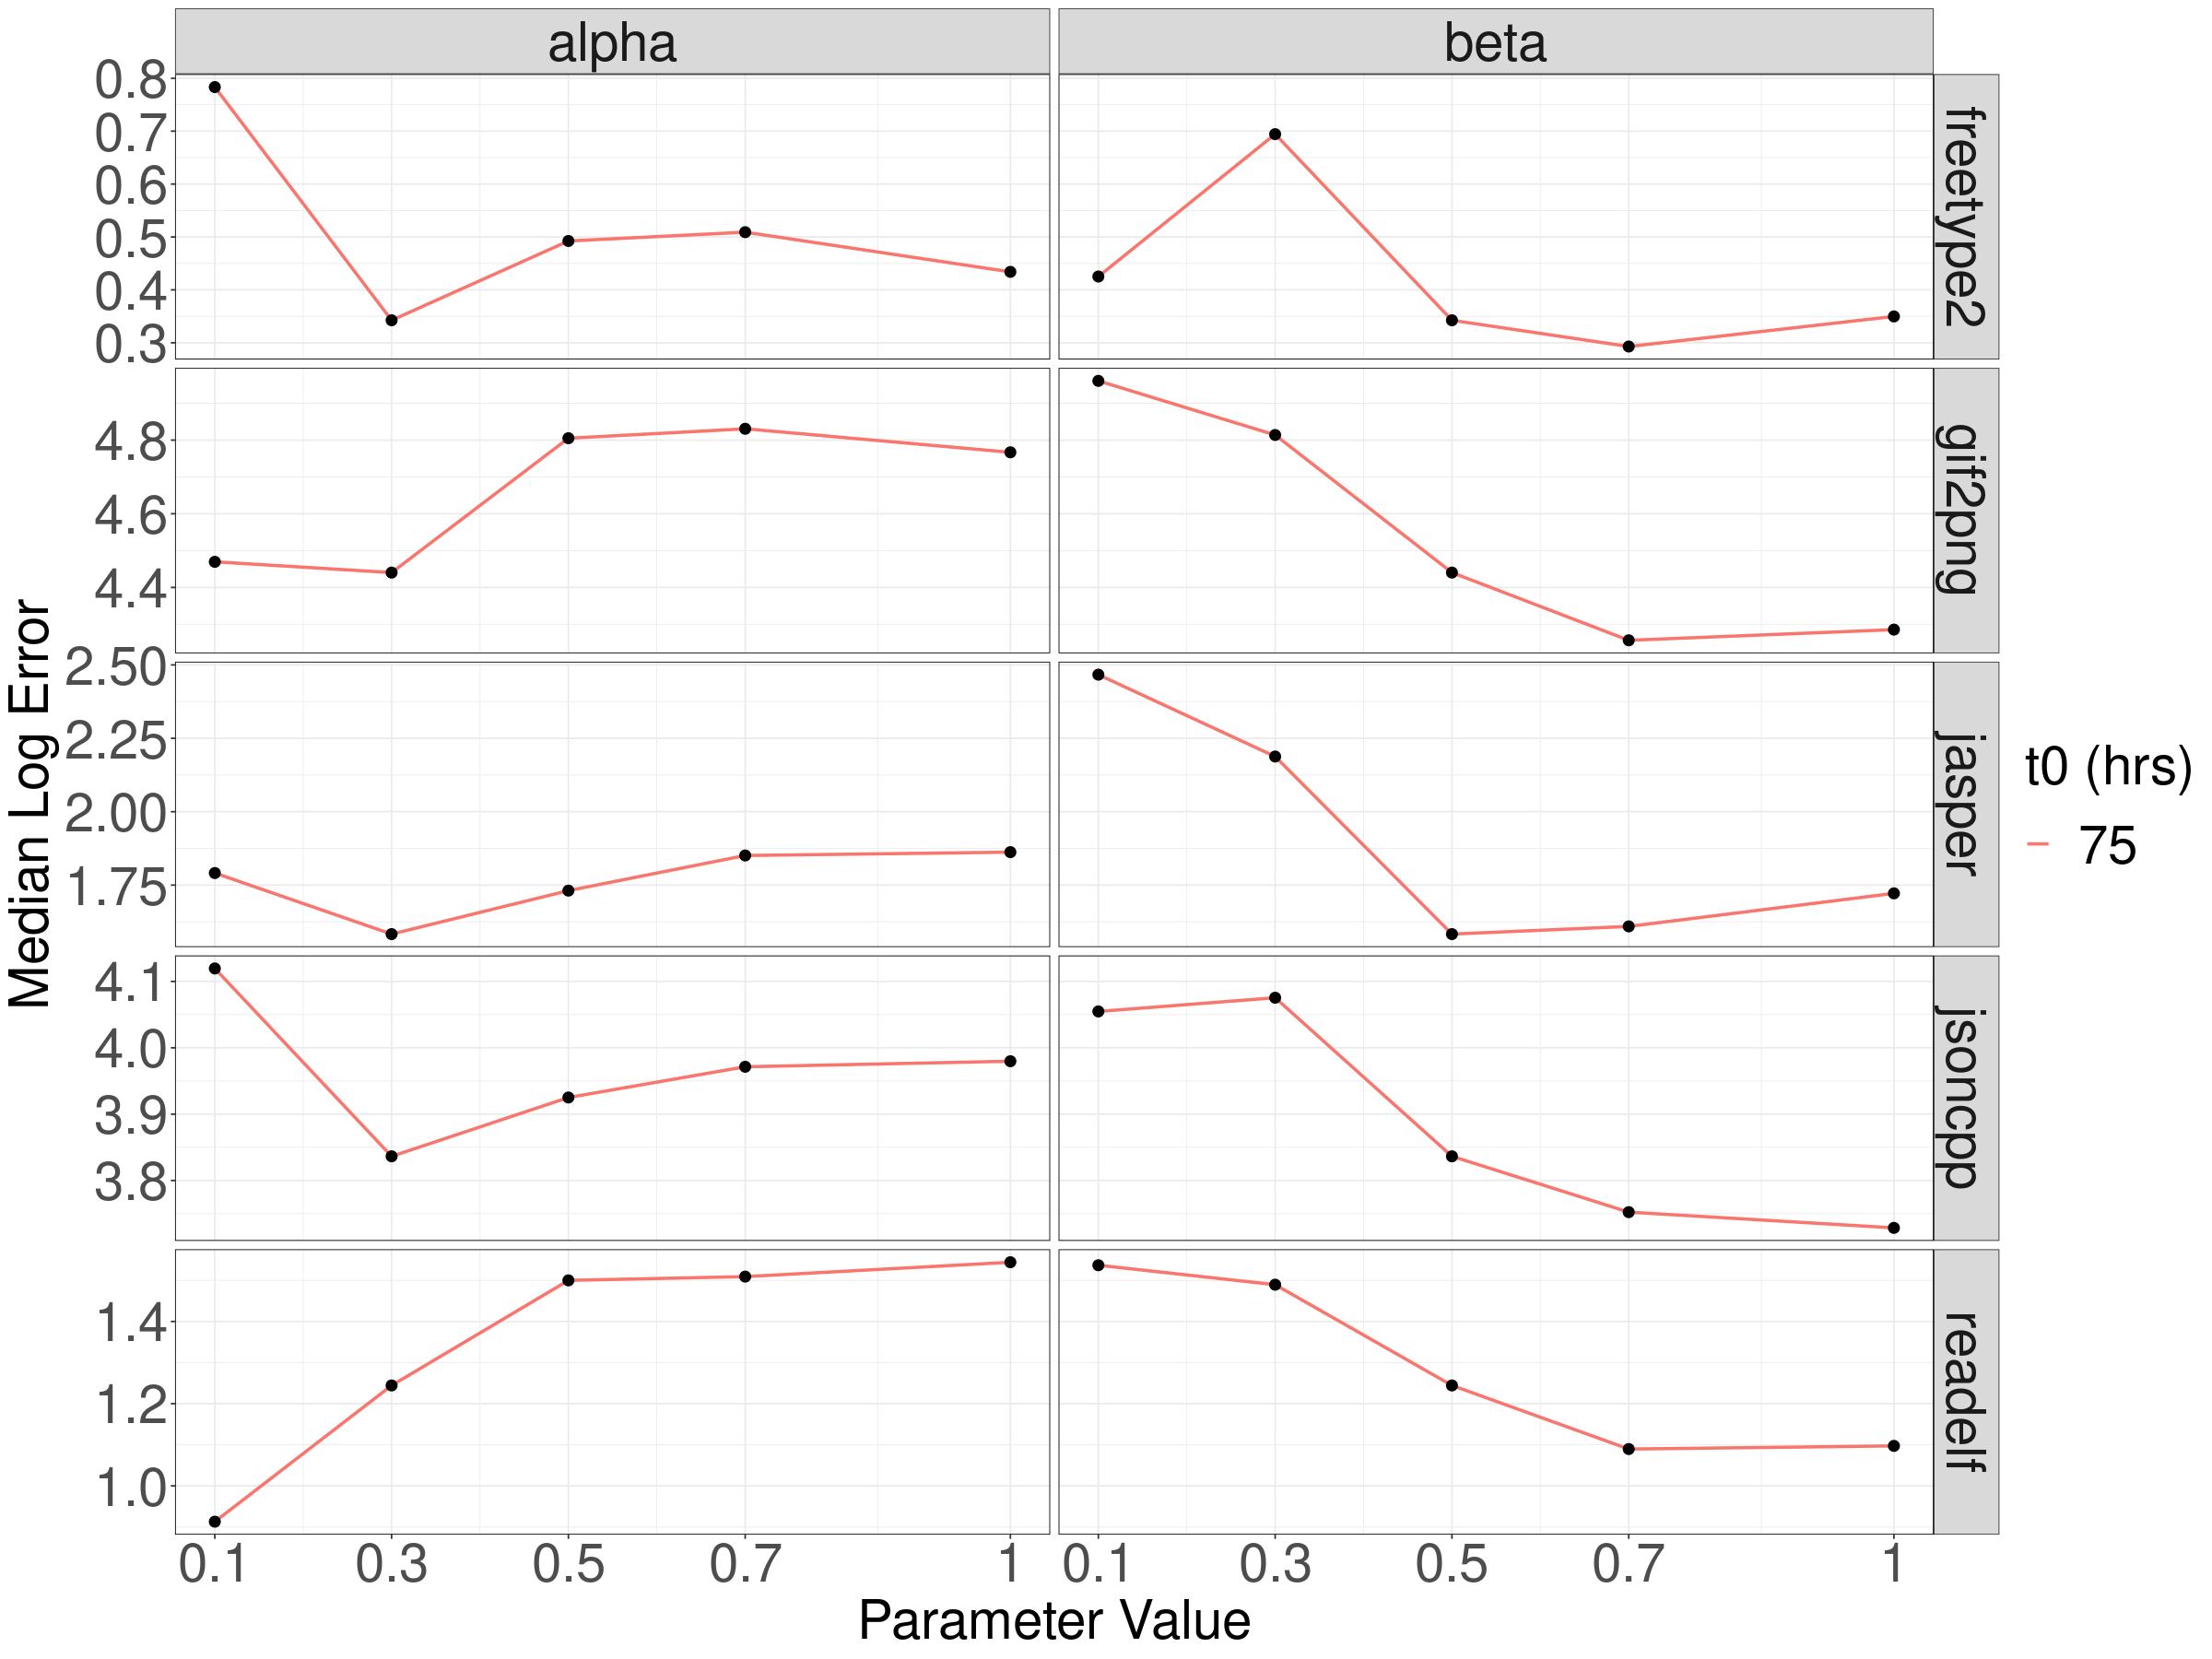

In [24]:
## Compute Mean Squared Error
mse_result = extrapolated %>%
            filter(theta0>=100) %>%
            merge(gt_data,by=c("subject","run","theta"),all.x=TRUE) %>%
            mutate(delta_new=log(delta_new),ground=log(ground_ma)) %>%
            group_by(subject,run,theta0,alpha,gamma,prop) %>%
            summarize(bias_new=mean(delta_new-ground), .groups = "drop") %>%
            ungroup()

mse_result = mse_result %>%
                group_by(subject,run,theta0,alpha,gamma,prop) %>%
                pivot_longer(!c(subject,run,theta0,alpha,gamma,prop),names_to = "method", values_to = "value") %>%
                ungroup()


mse_res = mse_result %>%
        filter(method=="bias_new") %>%
        arrange(theta0) %>%
        mutate(theta0 = theta0*(1/4)) %>% 
        rename(beta=gamma) %>%
        filter(prop==1) %>%
        group_by(subject,theta0,prop,alpha,beta) %>%
        summarize(value = median(value),.groups="drop") %>%
        ungroup()        

p1 = mse_res %>%
        filter(beta==0.5) %>%
        group_by(subject,theta0,prop,alpha) %>%
        summarize(value = median(value),.groups="drop") %>%
        ungroup() %>%
        group_by(subject,theta0,prop) %>%
        pivot_longer(!c(subject,theta0,prop,value),names_to = "parameter", values_to = "param_val")

p2 = mse_res %>%
        filter(alpha==0.3) %>%
        group_by(subject,theta0,prop,beta) %>%
        summarize(value = median(value),.groups="drop") %>%
        ungroup() %>%
        group_by(subject,theta0,prop) %>%
        pivot_longer(!c(subject,theta0,prop,value),names_to = "parameter", values_to = "param_val")

mse_res = rbind(p1,p2)

options(repr.plot.width = 20, repr.plot.height = 15)
pp = mse_res %>%
filter(theta0==75) %>%
  mutate(param_val = as.numeric(as.character(param_val)), theta0 = factor(theta0)) %>%
  ggplot(aes(x = param_val, y = value, color = theta0, group = theta0)) +
  geom_line(size = 1) +
  geom_point(size = 3,color="black") +
  facet_grid(subject ~ as.character(parameter), scales = "free_y") +
  labs(x = "Parameter Value", y = "Median Log Error") +
  theme_bw() +
  theme(panel.border = element_rect(color = "black"), 
        legend.title = element_text(size = 35),
        axis.text.x = element_text(size = 35),
        axis.title.x = element_text(size = 35),
        axis.text.y = element_text(size = 35),
        axis.title.y = element_text(size = 35),
        legend.text = element_text(size = 35),
        strip.text = element_text(size = 35),
        strip.text.x = element_text(size = 35)) +
  scale_color_discrete(name = "t0 (hrs)") +
  scale_x_continuous(breaks = c(0.1, 0.3, 0.5, 0.7, 1), labels = c("0.1", "0.3", "0.5", "0.7", "1"))

# Save the plot with the alpha and beta parameters
pp
ggsave(paste("../figures/", "Figure-8", ".pdf", sep = ""), plot = pp, width = 20, height = 15, family = "Helvetica")

### Appendix - A

The extrapolator performance is evaluated here without add-1 strategy for incidence frequancies. 
We subtract 1 from f1 and f2 to revert the add-1 changes and regenerate the plot.

In [25]:
# Load data again
load(file="../data/bb_data_1.Rdata")
load(file="../data/bb_data_2.Rdata")
load(file="../data/bb_data_3.Rdata")
load(file="../data/extrapolated.Rdata")
    
# Combine bb_data to a single data frame
bb_data = rbind(bb_data_1,bb_data_2,bb_data_3)

# Data filtering
bb_data = bb_data %>% filter(!(subject=="jasper" & run %in% exclude_runs))
extrapolated = extrapolated %>% filter(!(subject=="jasper" & run %in% exclude_runs))

# Smoothing singleton (f1) and doubleton (f1) counts to make existing extrapolation possible
smooth_bb_df = bb_data %>%
                mutate(f1_gb = f1_gb - 1,f2_gb = f2_gb - 1) %>%
                group_by(subject,run,theta) %>%
                summarise_at(vars(-c(repetition,theta0)),mean,na.rm=TRUE) %>%
                mutate(smooth_f1_gb=predict(loess(f1_gb ~ theta, span=0.2)),
                       smooth_f2_gb=predict(loess(f1_gb ~ theta, span=0.2)),
                       smooth_f1_gb=ifelse(smooth_f1_gb<0,0,smooth_f1_gb),
                       smooth_f2_gb=ifelse(smooth_f2_gb<0,0,smooth_f2_gb)) %>%
                select(subject,run,theta,smooth_f1_gb,smooth_f2_gb) %>%
                rename(theta0=theta)

extrapolated = merge(extrapolated,smooth_bb_df,by=c("subject","run","theta0"),all.x=TRUE)

## Existing extrapolator
hat_snm = function(f1,f2,theta,m){
    f0_hat = ifelse(f2!=0,((theta-1)/(theta))*((f1^2)/(2*f2)),((theta-1)/(theta))*((f1*(f1-1))/(2)))
    est = f0_hat*(1-((1-(f1/(theta*f0_hat+f1)))^m)) - f0_hat*(1-((1-(f1/(theta*f0_hat+f1)))^(m-1)))
    est = ifelse(is.nan(est),0,est)
    return(est)
}

# Recompute existing extrapolation using smooth data
extrapolated = extrapolated %>%
            mutate(delta_existing=as.numeric(hat_snm(smooth_f1_gb,smooth_f2_gb,theta0,(theta-theta0))))

head(extrapolated)

subject   run theta0 prop theta delta_existing delta_new sn_gb smooth_f1_gb
1 freetype2 1   50     2     89   0.97986615     8.303428  6243  233.1989    
2 freetype2 1   50     2     91   0.90452081     8.059109  6282  233.1989    
3 freetype2 1   50     2     88   1.01986069     8.430457  6243  233.1989    
4 freetype2 1   50     2     92   0.86904940     7.941586  6283  233.1989    
5 freetype2 1   50     3    113   0.37513575     6.022236  6348  233.1989    
6 freetype2 1   50     3    154   0.07275293     3.966931  6500  233.1989    
  smooth_f2_gb
1 233.1989    
2 233.1989    
3 233.1989    
4 233.1989    
5 233.1989    
6 233.1989

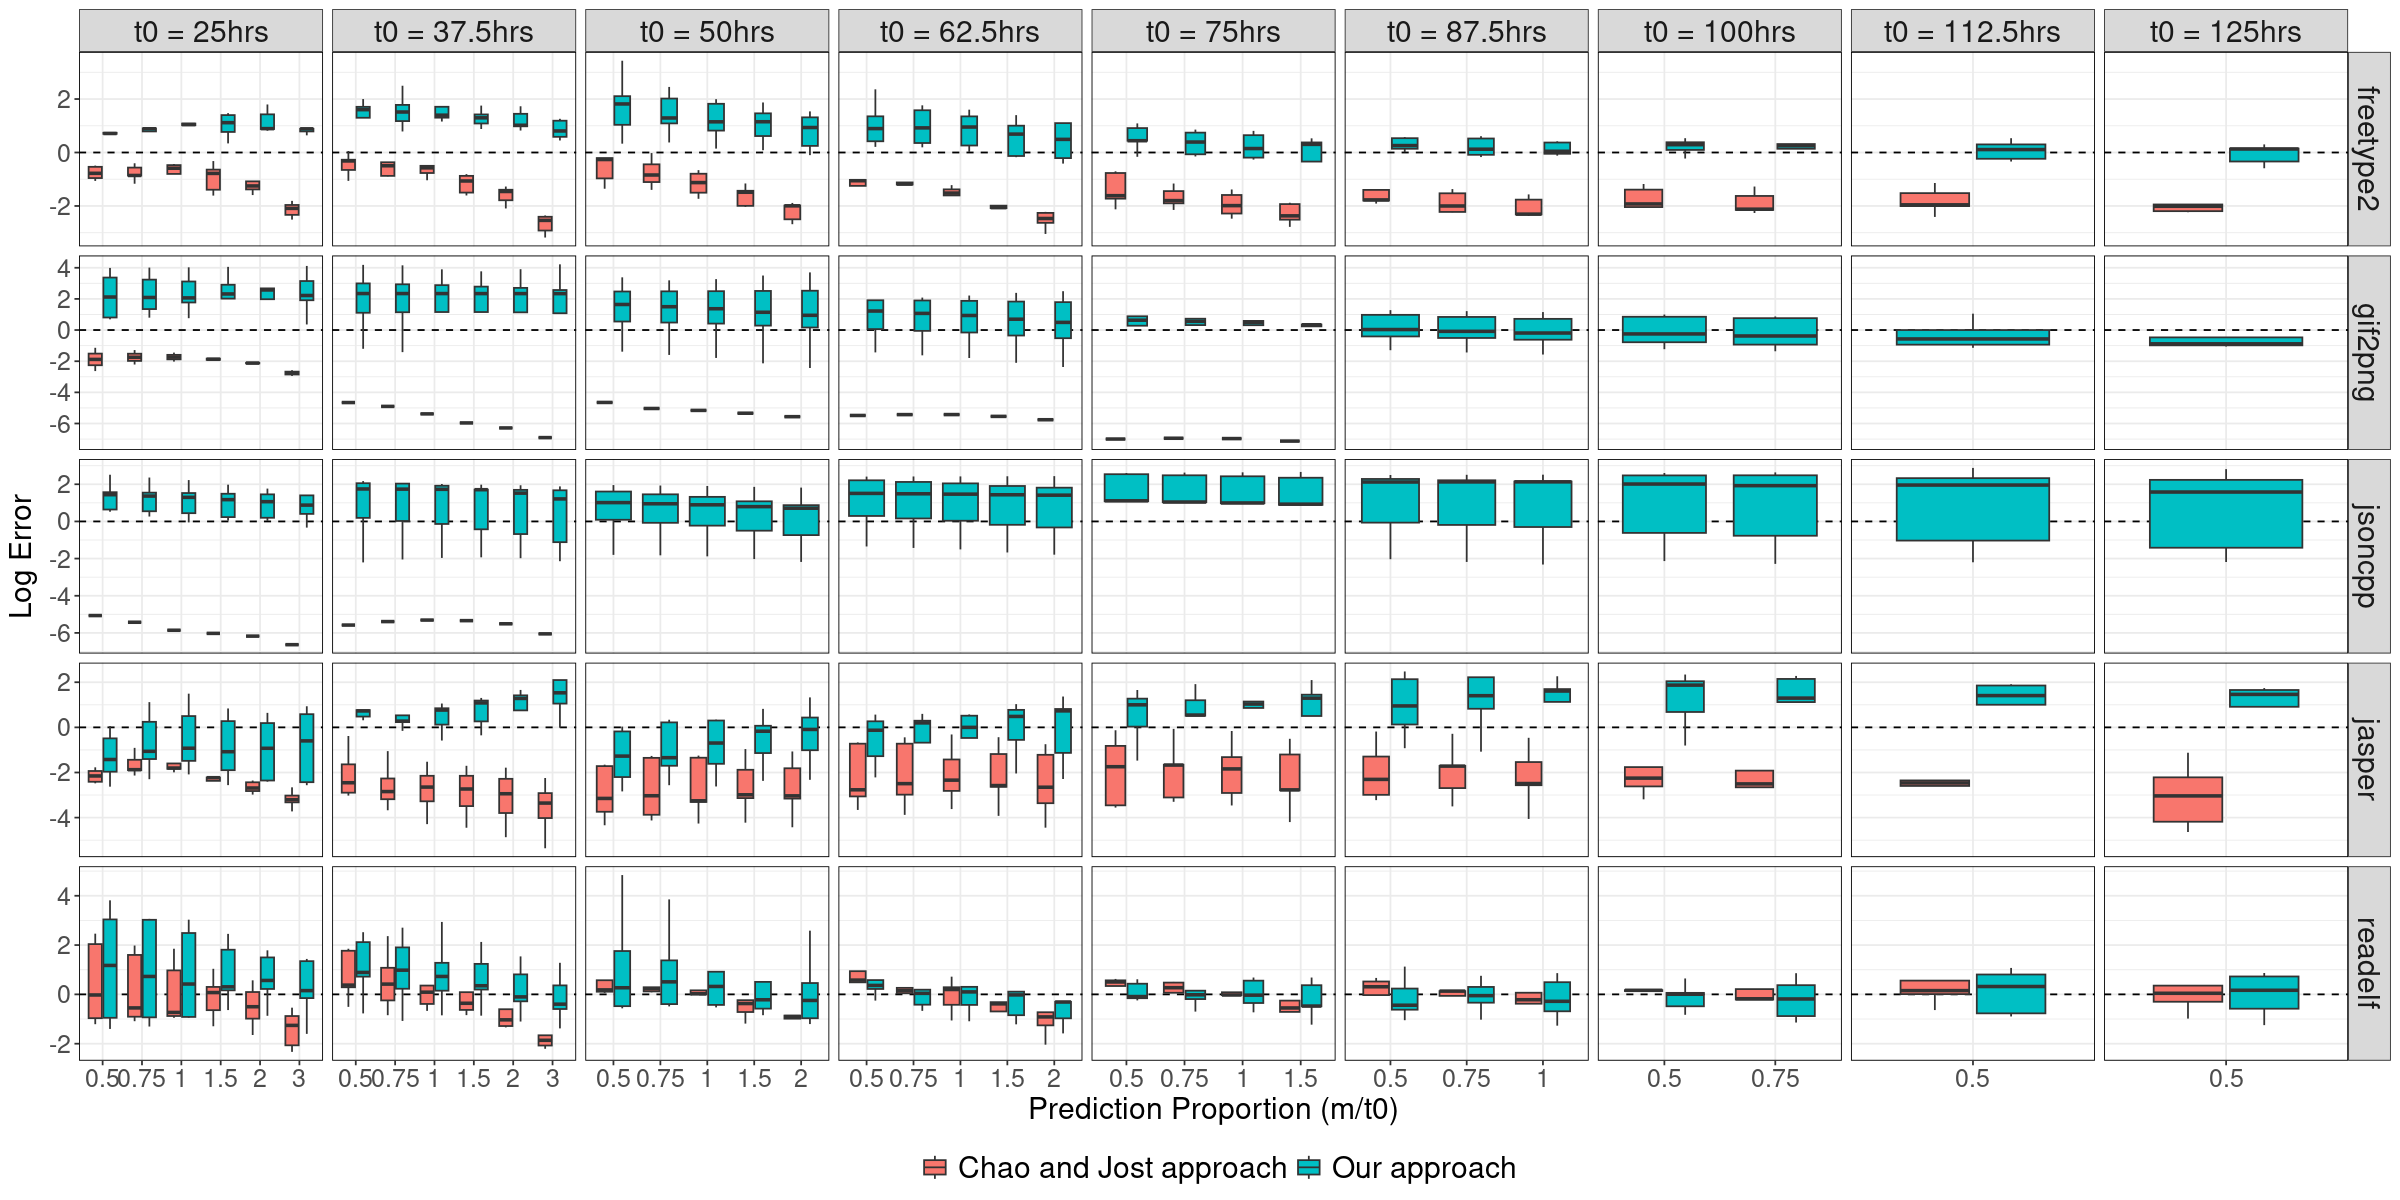

In [26]:
## Compute Mean Bias of Extrapolations
bias_df = extrapolated %>%
            filter(theta0>=100) %>%
            merge(gt_data,by=c("subject","run","theta"),all.x=TRUE) %>%
            mutate(delta_existing=log(delta_existing),delta_new=log(delta_new),ground=log(ground_ma)) %>%
            group_by(subject,run,theta0,prop) %>%
            summarize(bias_existing=mean(delta_existing-ground,na.rm=TRUE),
                      bias_new=mean(delta_new-ground,na.rm=TRUE), .groups = "drop") %>%
            ungroup()

bias_df = bias_df %>%
            filter((theta0+prop*theta0)<=max(theta0)) %>%
            group_by(subject,run,theta0,prop) %>%
            pivot_longer(!c(subject,run,theta0,prop),names_to = "method", values_to = "value") %>%
            ungroup()

options(repr.plot.width = 20, repr.plot.height = 10)

p1 = bias_df %>%
        filter(method == "bias_existing" | method == "bias_new") %>%
        mutate(method = ifelse(method == "bias_existing", "Chao and Jost approach", "Our approach")) %>%
        arrange(theta0) %>%
        mutate(theta0 = as.factor(theta0 * (1/4))) %>%
        mutate(prop = factor(prop), theta0 = factor(paste("t0 = ", theta0, "hrs", sep = ""),
                                                  c(paste("t0 = ", seq(50, 500, by = 50) * (1/4), "hrs", sep = "")))) %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 0.5) +
        geom_boxplot(aes(x = prop, y = value, fill = method),outlier.shape = NA, outlier.colour = NA) +
        labs(x="Prediction Proportion (m/t0)") +
        theme_bw() +
        theme(panel.border = element_rect(color = "black"),
         legend.title = element_blank(),legend.position = "bottom",
         axis.text.x=element_text(size=15),axis.title.x=element_text(size=18),
         axis.text.y=element_text(size=15),axis.title.y=element_text(size=18),
         legend.text=element_text(size=18),
         strip.text.x = element_text(size=18),strip.text.y = element_text(size=18)) +
        scale_y_continuous("Log Error", breaks = pretty_breaks()) + 
        facet_grid(subject~theta0,scales="free")

plot_grid(p1, ncol = 1, align = "v")
ggsave("../figures/Appendix-A.pdf",width=20,height=15)